# Introduction

In this notebook we will study eigenportfolios constructed from US equities. Our analysis will be based mostly on the paper <a href="https://math.nyu.edu/~avellane/AvellanedaLeeStatArb071108.pdf">Statistical Arbitrage in the U.S. Equities Market</a> by Marco Avellaneda and Jeong-Hyun Lee. The main idea is that we can perform principal components analysis (PCA) on the correlation matrix of stocks to design portfolios which are linearly independent of each other. More precisely, we can find a set of portfolios which are all uncorrelated with each other. The leading eigenportfolio roughly tracks the entire market, so we can think of investing in the sub-leading eigenportfolios as giving us a market-neutral strategy.

It is important to emphasize though that two quantities can be statistically dependent, but still uncorrelated. Two quantities are uncorrelated if there is no *linear* relation between them. Two quantities can be statistically dependent, but uncorrelated, if they obey some non-linear relations. Therefore, there is no guarentee that the sub-leading eigenportfolios are actually market neutral, but removing linear dependence does seem like a simple and potentially useful starting point.

In this notebook we will construct eigenportfolios using stocks from the S&P 500 as well as the Dow Jones Industrial (DJI) average. The DJI is a price-weighted index of 30 companies while the S&P 500 tracks the 500 largest stocks, as weighted by market capatilization. Of course the stocks in the DJI are a subset of the stocks in the S&P-500, but we perform a separate analysis since we are curious if it is safer to make eigenportfolios from a smaller or larger basket of stocks. For both cases we visualize how the stocks are correlated and see to what extent the top eigenportfolios explain the variance in the S&P-500 and DJI. We also compute the Sharpe Ratios and beta-coefficients for the eigenportfolios. Finally, we also fit the eigenportfolios using time-series models. In particular, we use ARIMA models to fit the mean returns of the portfolios and GARCH models to fit their volatility.

The rest of this notebook is organized as follows:

* **Dependencies**: This section contains boiler-plate code and imports useful libraries and functions which we use throughout the notebook.

* **Definitions and Data**: Here we scrape Wikipedia to get a list of the stocks in the S&P-500 and DJI. We also define some useful functions for downloading stocks, splitting and normalizing the data, and producing useful visualizations.

* **Data Processing**: We perform basic preprocessing, including calculating the stock returns, winsorizing the data to remove outliers, and normalizing the data. When normalizing the data we only use statistics from the training set to avoid data leakage.

* **EDA**: In this section we visualize the return and volatility of the stocks on test set. We also produce heat maps to visualize clustered correlation matrices. Finally, we visualize how much variance in the S&P-500 and DJI is explained by the top eigenportfolios and the weights for each stock in the top eigenportfolios.

* **Sharpe Ratio and Beta**: Here we compute the Sharpe-Ratio and Beta coefficients for the top eigenportfolios. As a reminder, the Sharpe ratio is a ratio of a stocks returns (relative to a risk-free rate) to its volatility and beta measures the market risk of a stock.

* **Time-Series Predictions**: Finally, we fit ARIMA models to the mean returns of the top eigenportfolios of the S&P-500 and DJI. We find that the return is best fit by a constant value. We then fit the volatility of the portfolios using GARCH models. We measure the performance of the fit using the Bayesian Information Criteria (BIC) and root mean squared error (RMSE).


In the future, we will add to this notebook to see how eigenportfolios compare against other portfolio constructions, such as heirarchical risk parity and inverse volatility portfolios (some preliminary work can be found in the notebook hiearchical_risk_parity.ipynb).

# Dependencies

Here we import necessary libraries and functions for this noteobok. In particular, we install the arch library which is necessary for the time-series analysis.

In [8]:
!pip install arch

import os
import pandas as pd
import pandas_datareader as web
import yfinance as yf
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from numpy.linalg import inv, eig, svd
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

from matplotlib.ticker import FuncFormatter

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error
from numpy.linalg import LinAlgError

from arch import arch_model

import warnings
warnings.filterwarnings('ignore')

# Definitions and Data

In [55]:
def download_stocks(tickers,start='2014-01-01',end='2018-01-01'):
    """
    Downloads equity data from Yahoo Finance.
    
    Inputs:
    -------
    - tickers (List[str]): List of strings containing the tickers.
    - start (str): Start date for stock data.
    - end (str): End date for stock data.
    
    Output:
    - Pandas dataframe containing full stock data.
    """
    return yf.download(tickers, start = start, end = end)

def remove_null(df):
    """
    Removes null values from Pandas dataframe.
    
    Inputs:
    -------
    - df (Pandas DataFrame): Contains stock prices.
    
    Output:
    - Pandas Dataframe with all stocks with null values removed.
    """
    df = df.dropna(axis=1)
    return df

def winsorize(df,q=.025):
    """
    Clip financial data to remove outliers.
    
    Inputs:
    -------
    - df (Pandas DataFrame): Contains stock data with null values removed.
    - q (float): quantile at which to clip prices. Clip stocks at q-th and (1-q)-th quantile.
    
    Outputs:
    - Pandas dataframe with large outliers clipped to specified quantile.
    
    """
    clipped = df.clip(lower=df.quantile(q=q),
                   upper=df.quantile(q=1-q),
                   axis=1)
    return clipped

def df_scaler(df):
    """
    Produces a StandardScaler object which sets input df to have zero mean and unit variance.
    
    Inputs:
    ------
    - df (Pandas Dataframe): Dataframe with unnormalized data.
    
    Outputs:
    --------
    - scaler: Sklearn StandardScaler which can be used to transform other dataframes.
    """
    scaler = StandardScaler().fit(df)
    return scaler

def train_test_split(df,percentage = .8):
    """
    Splits time-series data into train and test-sets.
    
    Inputs:
    -------
    - df (Pandas DataFrame): Dataframe containing time-series data.
    - percentage (float): Fraction of data to keep in the train set. Rest is put in test set.
    
    Outputs:
    - train_set, test_set (Tuple(DataFrames)): Train and test datasets.
    """
    
    # Use int to round len(df)*percentage to the smallest, nearest integer.
    train_size = int(len(df)*percentage) 
    train_set = df[:train_size]
    test_set = df[train_size:]

    return train_set, test_set

def get_distance_matrix(corr):
    """Compute distance matrix from correlation;
    0 <= d[i,j] <= 1"""
    return np.sqrt((1 - corr) / 2)

def clustered_corr_plot(df,include_ticks = True,title=None):
    
    """
    Produces a heatmap for a clustered correlation matrix.
    
    Inputs:
    -------
    - df (Pandas DataFrame): Contains stock data in columnar format.
    - include_ticks (bool): Whether or not to include x- and y-axis ticks.
    
    Output:
    ------
    - returns figure object for plot.
    """
    
    corr = df.corr()

    distance_matrix = get_distance_matrix(corr)
    linkage_matrix = linkage(squareform(distance_matrix), 'single')
    #sorted_idx = quasi_diagonalize(linkage_matrix)

    clustergrid = sns.clustermap(distance_matrix,
                             method='single',
                             row_linkage=linkage_matrix,
                             col_linkage=linkage_matrix,
                             center=0);
    plt.close()

    sorted_idx = clustergrid.dendrogram_row.reordered_ind
    sorted_tickers = corr.index[sorted_idx].tolist()
    fig, ax = plt.subplots(figsize=(18, 8))

    clustered_assets = corr.loc[sorted_tickers, sorted_tickers]  # reorder

    sns.heatmap(clustered_assets, center = 0, ax=ax)
    
    if not title:
        ax.set_title('Clustered Correlation')
    else:
        ax.set_title(title)
    if not include_ticks:
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout();

    return fig

# Data Processing

We first download the data for the S&P-500 and DJI index. We then compute the percent return on the index and drop null values.

In [52]:
SP_index = download_stocks('^GSPC')['Adj Close']
DJI_index = download_stocks('^DJI')['Adj Close']

SP_idx_returns = SP_index.pct_change().dropna()
DJI_idx_returns = DJI_index.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Next, we use Pandas to get the list of stocks in the S&P-500 and DJI from Wikipedia.

In [22]:
# load dataset
#scraping wikipedia to fetch S&P 500 and DJI stock list
snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
SP_stocks = pd.read_html(snp500url)[0]
SP_tickers = SP_stocks['Symbol'].to_list()

DJI = (
    pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1]
)
DJI_symbols = DJI.Symbol.tolist()

Below we download data for all stocks in the S&P-500 and DJI.

In [25]:
SP_data = download_stocks(SP_tickers)['Adj Close']
SP_data.index = pd.to_datetime(SP_data.index)

DJI_data = download_stocks(DJI_symbols)['Adj Close']
DJI_data.index = pd.to_datetime(DJI_data.index)

[*********************100%***********************]  503 of 503 completed

14 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- OTIS: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- FOXA: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- CEG: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- CDAY: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- DOW: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- OGN: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- FOX: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- GEHC: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- CTVA: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- CARR: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- VICI: Data doesn't exist for s

To simplify our analysis, we remove any stocks that have null values. 

In [27]:
DJI_data = remove_null(DJI_data)
SP_data = remove_null(SP_data)

Next, we again use the built-in pct_change method to compute the returns for each stock and we again drop null values. 
To avoid outliers having too large an effect, we also Winsorize our data.

In [29]:
SP_returns = SP_data.pct_change().dropna()
DJI_returns = DJI_data.pct_change().dropna()

SP_returns = winsorize(SP_returns)
DJI_returns = winsorize(DJI_returns)

We then split out data into train and test sets, where we split the data chronologically. We then define the scaled train and test sets by subtracting by the mean and dividing by the standard deviation. Both the mean and standard deviation are computed on the training sets to avoid any data leakage.

In [32]:
SP_train, SP_test = train_test_split(SP_returns)
DJI_train, DJI_test = train_test_split(DJI_returns)

In [33]:
SP_train_scaled = (SP_train-SP_train.mean())/SP_train.std()
SP_test_scaled = (SP_test-SP_train.mean())/SP_train.std()

DJI_train_scaled = (DJI_train-DJI_train.mean())/DJI_train.std()
DJI_test_scaled = (DJI_test-DJI_train.mean())/DJI_train.std()

Below we look at the man and standard deviations on the rescaled training and test set. Specifically, we compute the mean and standard deviation for each stock return individually and then take average these two statistics across all stocks.

By definition, the rescaled training datasets have a mean of 0 and a standard deviation of 1. We observe however that the test sets have a non-zero, positive mean and a standard deviation below 1. This indicates that in the test set the stocks have both higher returns and a lower volatility.

In [34]:
print('Statistics for SP-500 train set')
print(f'Average normalized return: {SP_train_scaled.mean().mean()}')
print(f'Average standard deviation: {SP_train_scaled.std().mean()}')
print('\n')
print('Statistics for SP-500 test set')
print(f'Average normalized return: {SP_test_scaled.mean().mean()}')
print(f'Average standard deviation: {SP_test_scaled.std().mean()}')

Statistics for SP-500 train set
Average normalized return: 1.8397947973437945e-18
Average standard deviation: 1.0


Statistics for SP-500 test set
Average normalized return: 0.014682838738559188
Average standard deviation: 0.8280153049338941


In [35]:
print('Statistics for DJI train set')
print(f'Average normalized return: {DJI_train_scaled.mean().mean()}')
print(f'Average standard deviation: {DJI_train_scaled.std().mean()}')
print('\n')
print('Statistics for DJI test set')
print(f'Average normalized return: {DJI_test_scaled.mean().mean()}')
print(f'Average standard deviation: {DJI_test_scaled.std().mean()}')

Statistics for DJI train set
Average normalized return: -4.056913780153685e-18
Average standard deviation: 1.0


Statistics for DJI test set
Average normalized return: 0.028684149489964735
Average standard deviation: 0.7780340627564185


# EDA

To get a better sense of the data, it always helpful to visualize it using plots. In the first plots below we look at the mean and standard deviation of the (normalized) stock returns on the train and test set. By definition, the returns in the training set have 0 mean and unit variance. However, on the test sets we see that some stocks have higher/lower average returns and generally smaller volatility. This behavior is particularly pronounced when we plot stocks in the DJI. 

Note that to make the plots for the S&P-500 readable, we plotted a random smaple of 75 stocks. For the DJI we were able to plot all of them at once.

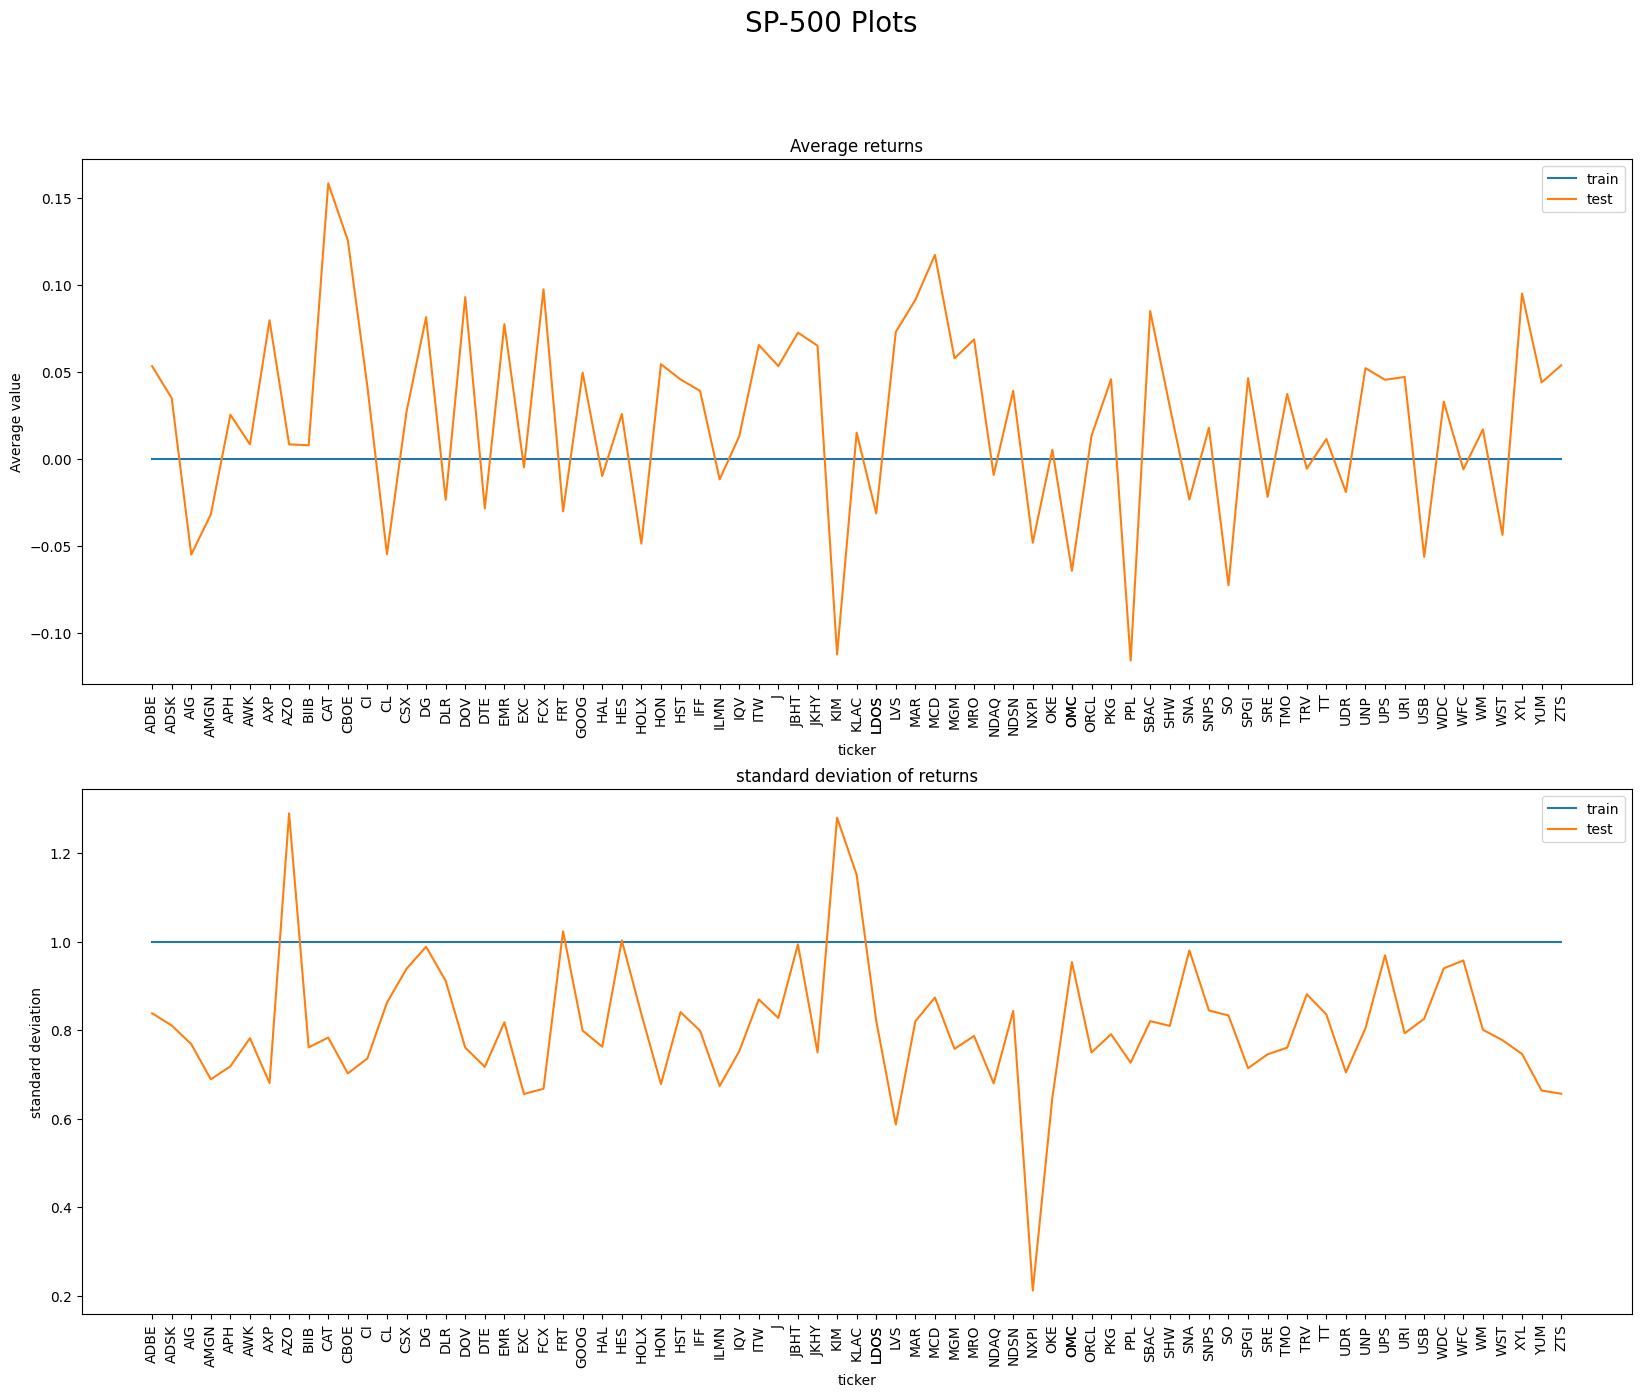

In [53]:
fig, axes = plt.subplots(2,sharex=False)
fig.set_size_inches(20, 15)

np.random.seed(110)

random_stocks = sorted(np.random.choice(SP_train_scaled.shape[1],75))
random_tickers = list(SP_train_scaled.columns[random_stocks])

SP_train_scaled_sample = SP_train_scaled[random_tickers]
SP_test_scaled_sample = SP_test_scaled[random_tickers]

axes[0].plot(SP_train_scaled_sample.mean(),label='train')
axes[0].plot(SP_test_scaled_sample.mean(),label='test')
axes[0].set_title('Average returns')
axes[0].set_ylabel('Average value')
axes[0].legend()

axes[0].set_xlabel('ticker')
axes[0].set_xticks(random_tickers)
axes[0].set_xticklabels(random_tickers,rotation=90)

#plt.draw()
#axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)

axes[1].plot(SP_train_scaled_sample.std(),label='train')
axes[1].plot(SP_test_scaled_sample.std(),label='test')
axes[1].set_title('standard deviation of returns')
axes[1].set_ylabel('standard deviation')
axes[1].legend()


axes[1].set_xlabel('ticker')
axes[1].set_xticks(random_tickers)
axes[1].set_xticklabels(random_tickers,rotation=90);

plt.suptitle('SP-500 Plots',fontsize=20)

plt.show();

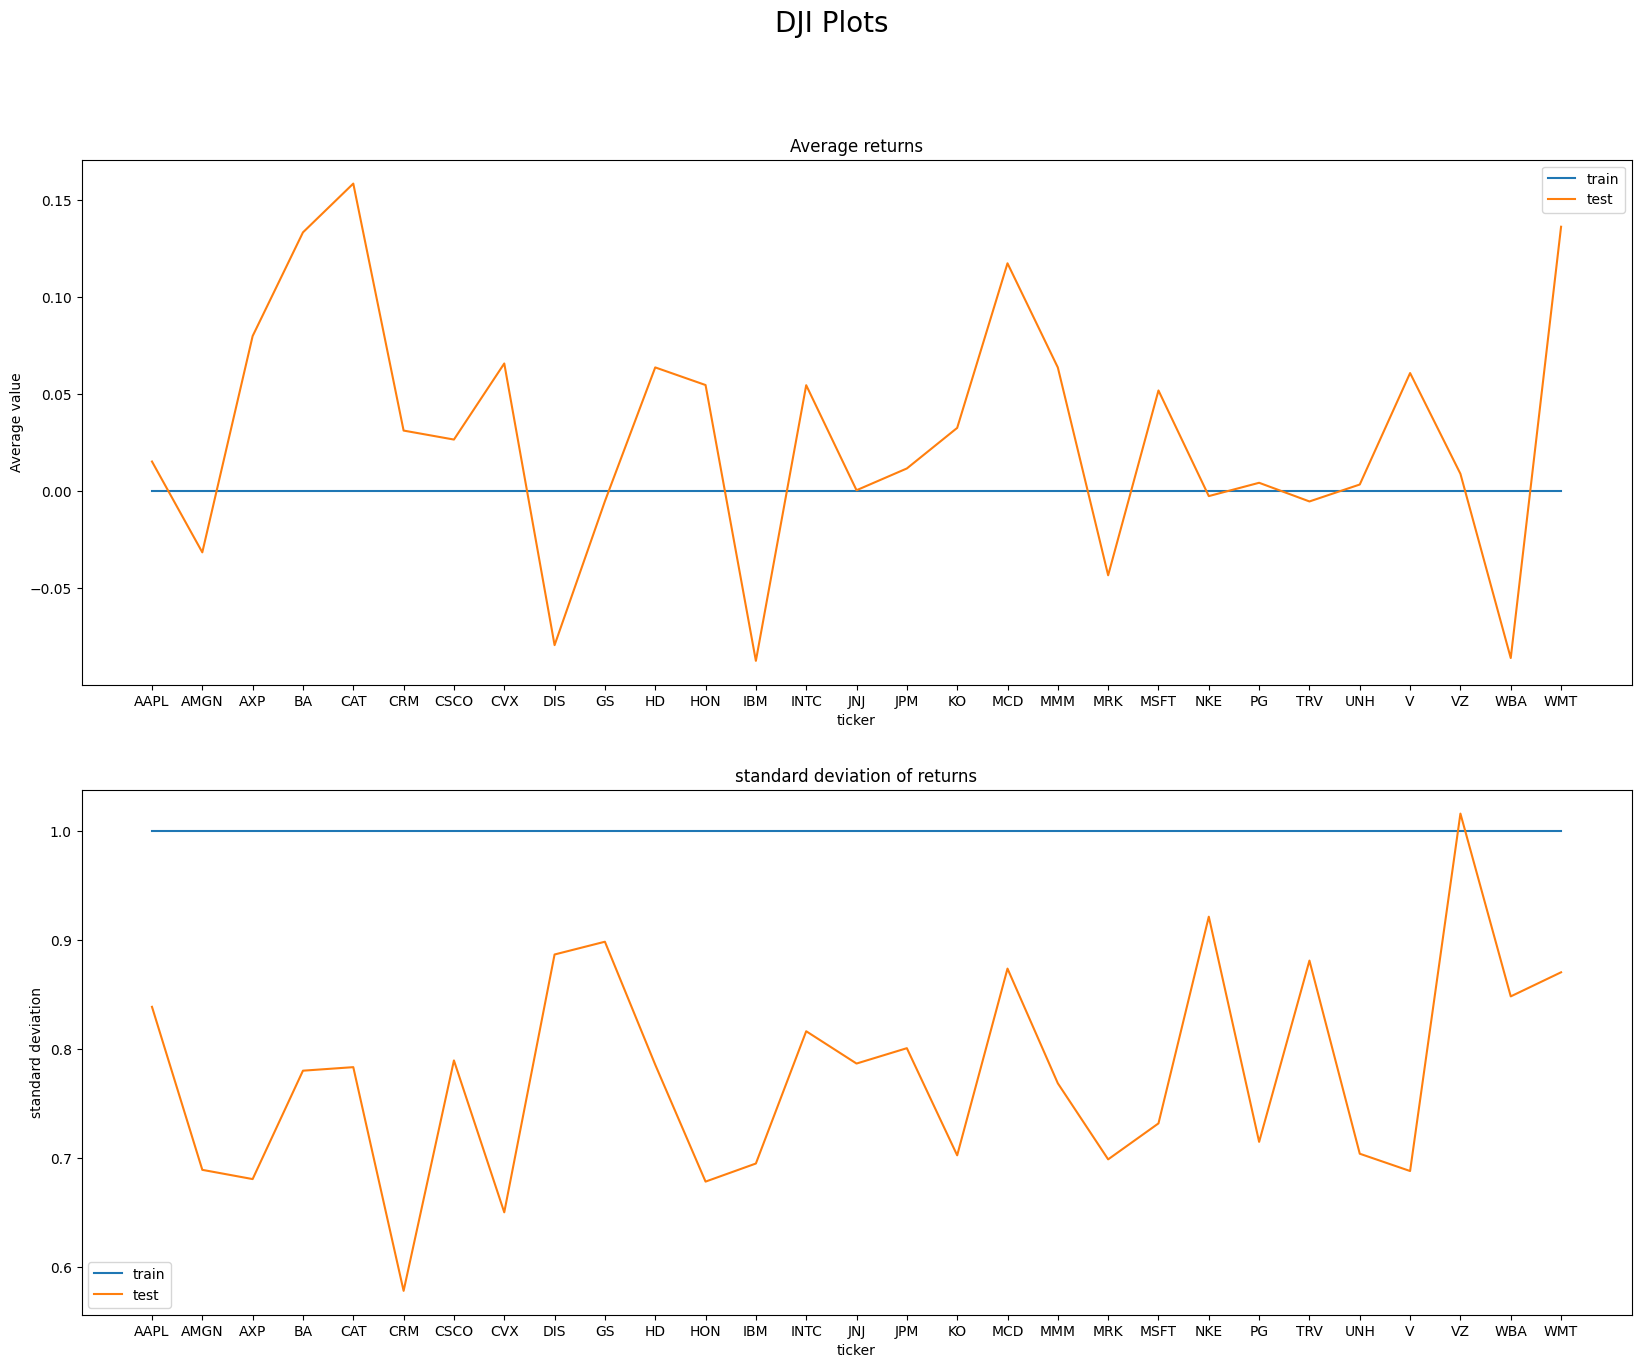

In [54]:
fig, axes = plt.subplots(2,sharex=False)
fig.set_size_inches(20, 15)

axes[0].plot(DJI_train_scaled.mean(),label='train')
axes[0].plot(DJI_test_scaled.mean(),label='test')
axes[0].set_title('Average returns')
axes[0].set_ylabel('Average value')
axes[0].legend()

axes[0].set_xlabel('ticker')
#axes[0].set_xticks(random_tickers)
#axes[0].set_xticklabels(random_tickers,rotation=90)

#plt.draw()
#axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)

axes[1].plot(DJI_train_scaled.std(),label='train')
axes[1].plot(DJI_test_scaled.std(),label='test')
axes[1].set_title('standard deviation of returns')
axes[1].set_ylabel('standard deviation')
axes[1].legend()


axes[1].set_xlabel('ticker')


plt.suptitle('DJI Plots',fontsize=20)

plt.show();

Next, let's look at how different stocks are correlated. For later convenience, below we define the covariance and correlation matrices of the stocks on the train and test set using the built-in .cov and .corr methods of Pandas DataFrames.

In [38]:
SP_train_cov = SP_train.cov()
SP_test_cov = SP_test.cov()

SP_train_corr = SP_train.corr()
SP_test_corr = SP_test.corr()

DJI_train_cov = DJI_train.cov()
DJI_test_cov = DJI_test.cov()

DJI_train_corr = DJI_train.corr()
DJI_test_corr = DJI_test.corr()

Below we made a clustered correlation plot for the DJI-500. In a clustered correlation plot we attempt to group stocks with higher correlation closer together to better visualize the overall structure of the market. For the DJI stocks we do not observe any significant clusters, although we do see that AXP, GS, and JPM are grouped together. This makes sense since these are all stocks in the financial sector.

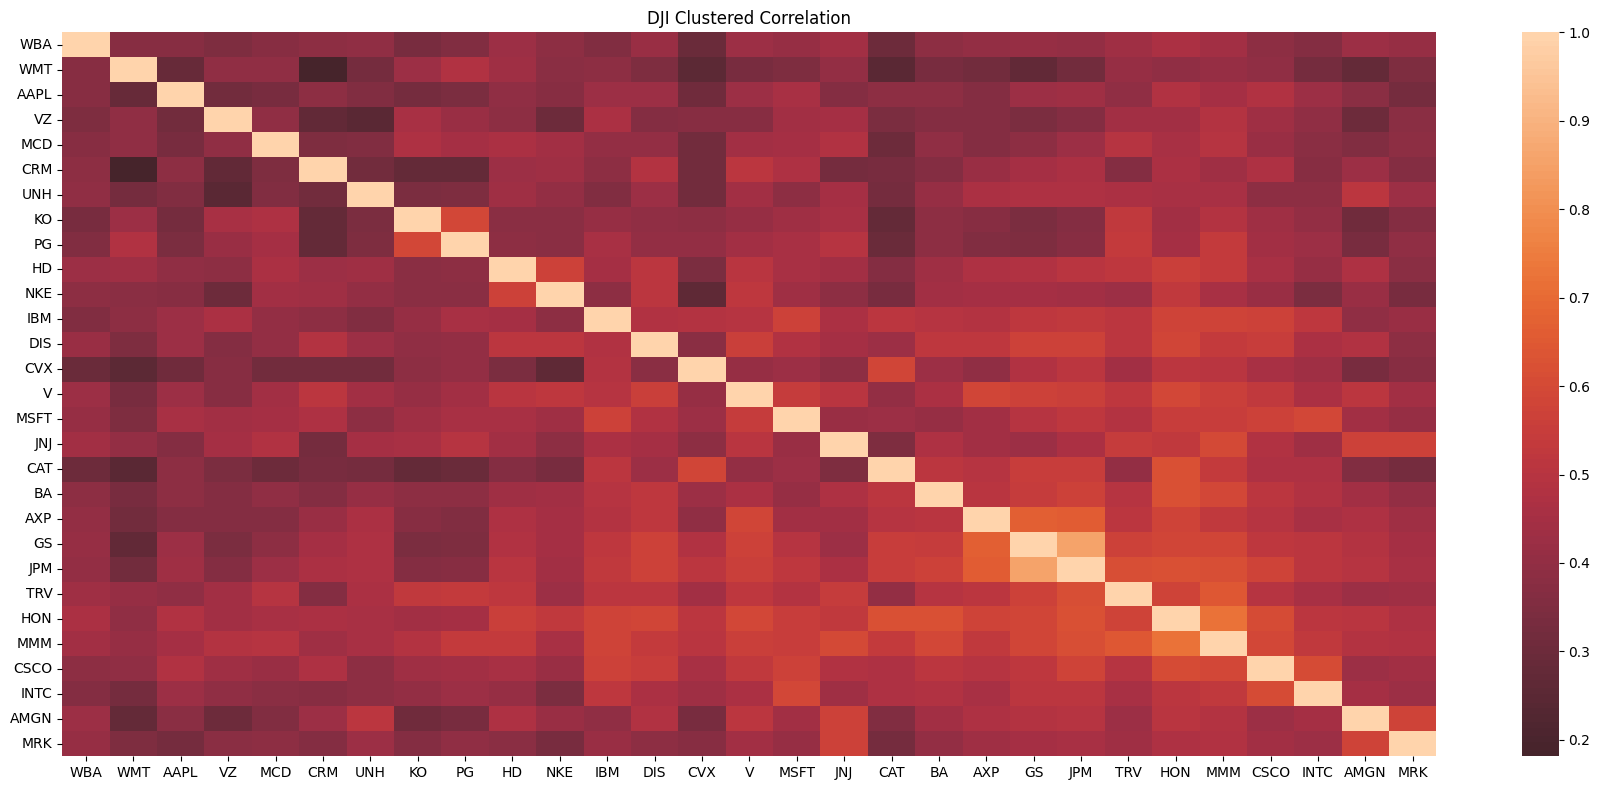

In [56]:
clustered_corr_plot(DJI_train,title='DJI Clustered Correlation');

If we make a similar plot for the SP-500 we observe more significant clustering. This is not surprising since the SP-500 contains more stocks, so we likely have more stocks from the same cluster. Of course, we have so many plots that it becomes impossible to include tick-labels and identify clusters by eye! For more work on clustering SP-500 data, see the file pair_trading.ipynb.

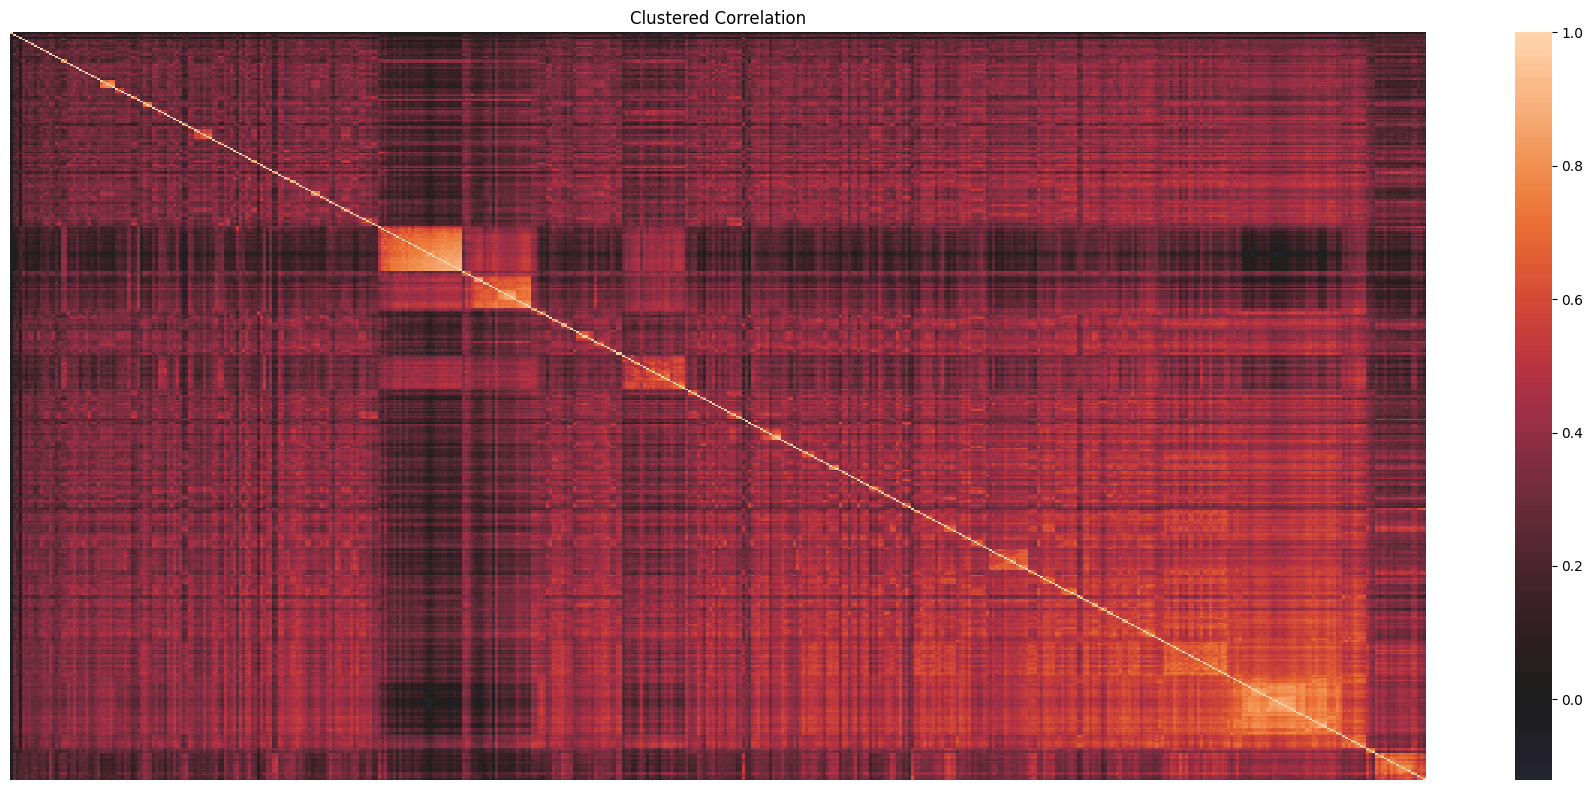

In [40]:
clustered_corr_plot(SP_train,title='DJI Clustered Correlation');

Next we will perform principal components analysis on the SP-500 and DJI training data. 

In [57]:
PCA_SP = PCA().fit(SP_train_scaled)
PCA_DJI = PCA().fit(DJI_train_scaled)

For the SP-500 we see that around 37-38% of the explained variance comes from just the first eigen-portfolio. From the second plot we see that to explain 80% of the variance we need to include approximately 100 eigenportfolios. 

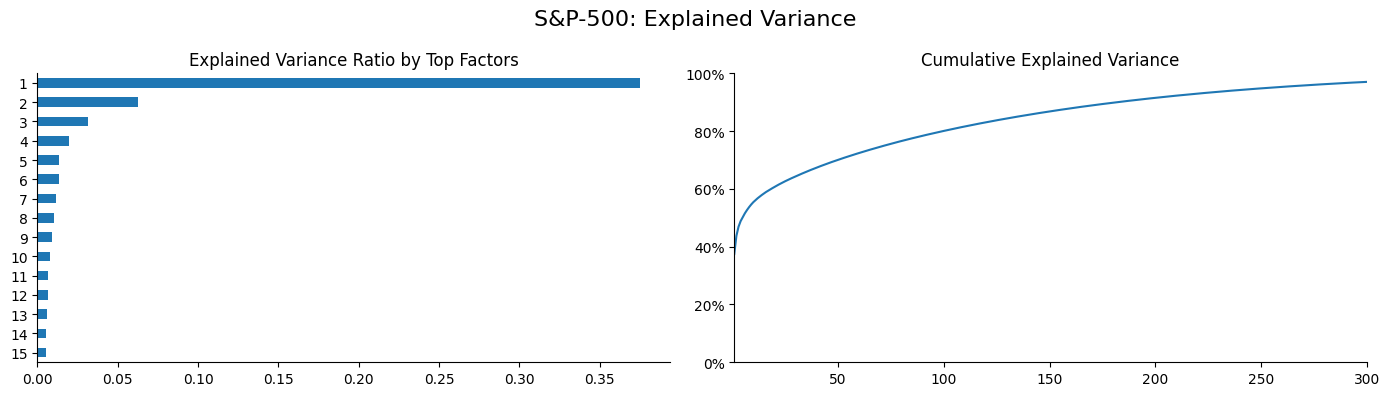

In [58]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(PCA_SP.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 300))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.suptitle("S&P-500: Explained Variance", size=16)
fig.tight_layout()

For the DJI stocks the top eigenportfolio explains approximately 46% of the cumulative variance. This is not suprising, since the top eigenportfolio is an approximately proxy for the market and the DJI stocks already make up a significant chunk of the entire market!

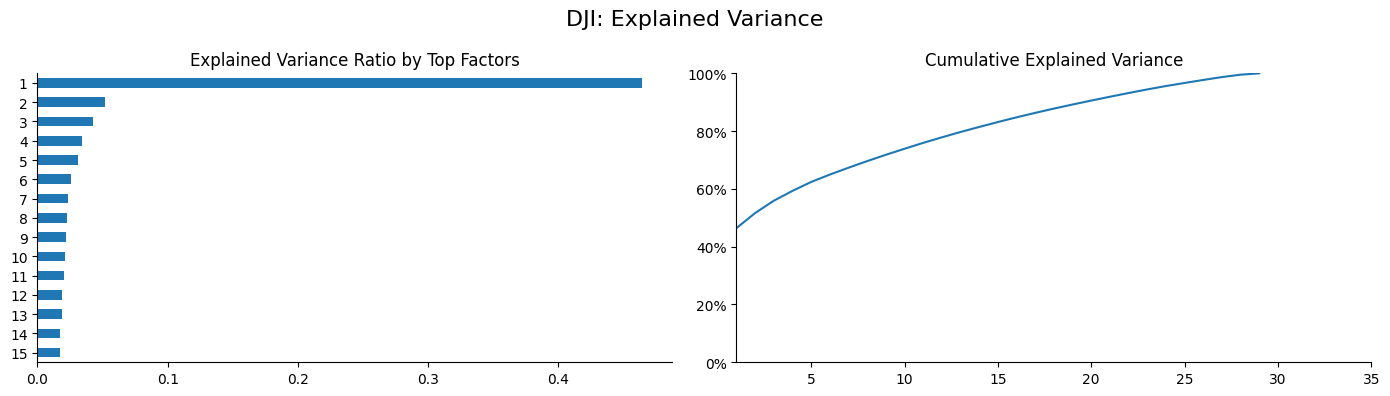

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(PCA_DJI.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 35))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.suptitle("DJI: Explained Variance", size=16)
fig.tight_layout()

Next let's construct the eigenportfolios by hand. We could use the sklearns PCA object to compute many of the quantities below, but we found it instructive to compute the eigenportfolios just using numpy functions.

The first thing we compute are the eigenvalue and eigenvectors of the correlation matrix for the SP and DJI stock returns. We also reorganize the eigenvalues and eigenvectors so that eigenvalues are sorted from largest to smallest and the associated eigenvectors are ranked in the same order.

In [66]:
SP_eigvals, SP_eigvecs = np.linalg.eigh(SP_train_corr)

SP_eigvals = SP_eigvals[::-1]
SP_eigvecs = SP_eigvecs[:,::-1]

DJI_eigvals, DJI_eigvecs = np.linalg.eigh(DJI_train_corr)

DJI_eigvals = DJI_eigvals[::-1]
DJI_eigvecs = DJI_eigvecs[:,::-1]

To construct eigenportfolios we need to divide tye eigenvectors by the volatility of each stock, see equation 9 of the original <a href="https://math.nyu.edu/~avellane/AvellanedaLeeStatArb071108.pdf">paper</a>.

In [ ]:
SP_evecs_std = (SP_eigvecs.T/(SP_train.std().values)).T

DJI_evecs_std = (DJI_eigvecs.T/(DJI_train.std().values)).T

Next we normalize each eigenvector to have unit norm to account for dividing by the volatility in the previous step.

In [48]:
for i in range(SP_evecs_std.shape[1]):
    SP_evecs_std[:,i]=SP_evecs_std[:,i]/np.linalg.norm(SP_evecs_std[:,i])

for i in range(DJI_evecs_std.shape[1]):
    DJI_evecs_std[:,i]=DJI_evecs_std[:,i]/np.linalg.norm(DJI_evecs_std[:,i])

Finally, we construct the returns for the eigenportfolios by taking the dot product of the SP and DJI return matrices with the vectors defined above, again see equation 9 of the <a href="https://math.nyu.edu/~avellane/AvellanedaLeeStatArb071108.pdf">paper</a>.

In [49]:
SP_eport_train = SP_train.dot(SP_evecs_std)
SP_eport_test = SP_test.dot(SP_evecs_std)

DJI_eport_train = DJI_train.dot(DJI_evecs_std)
DJI_eport_test = DJI_test.dot(DJI_evecs_std)

We can now see how much weight the top eigenportfolios put on each stock. For simplicity we focus on the DJI eigenportfolios since we have less stocks to consider. We observe that the top eigenportfolio has all positive weights, which aligns with our expectations that this is a proxy for the full market (in our basket of stocks). In order for the other eigenportfolios to be uncorrelated with the top portfolio they need to place negative weights in some stocks, i.e. they are implementing a long-short strategy.

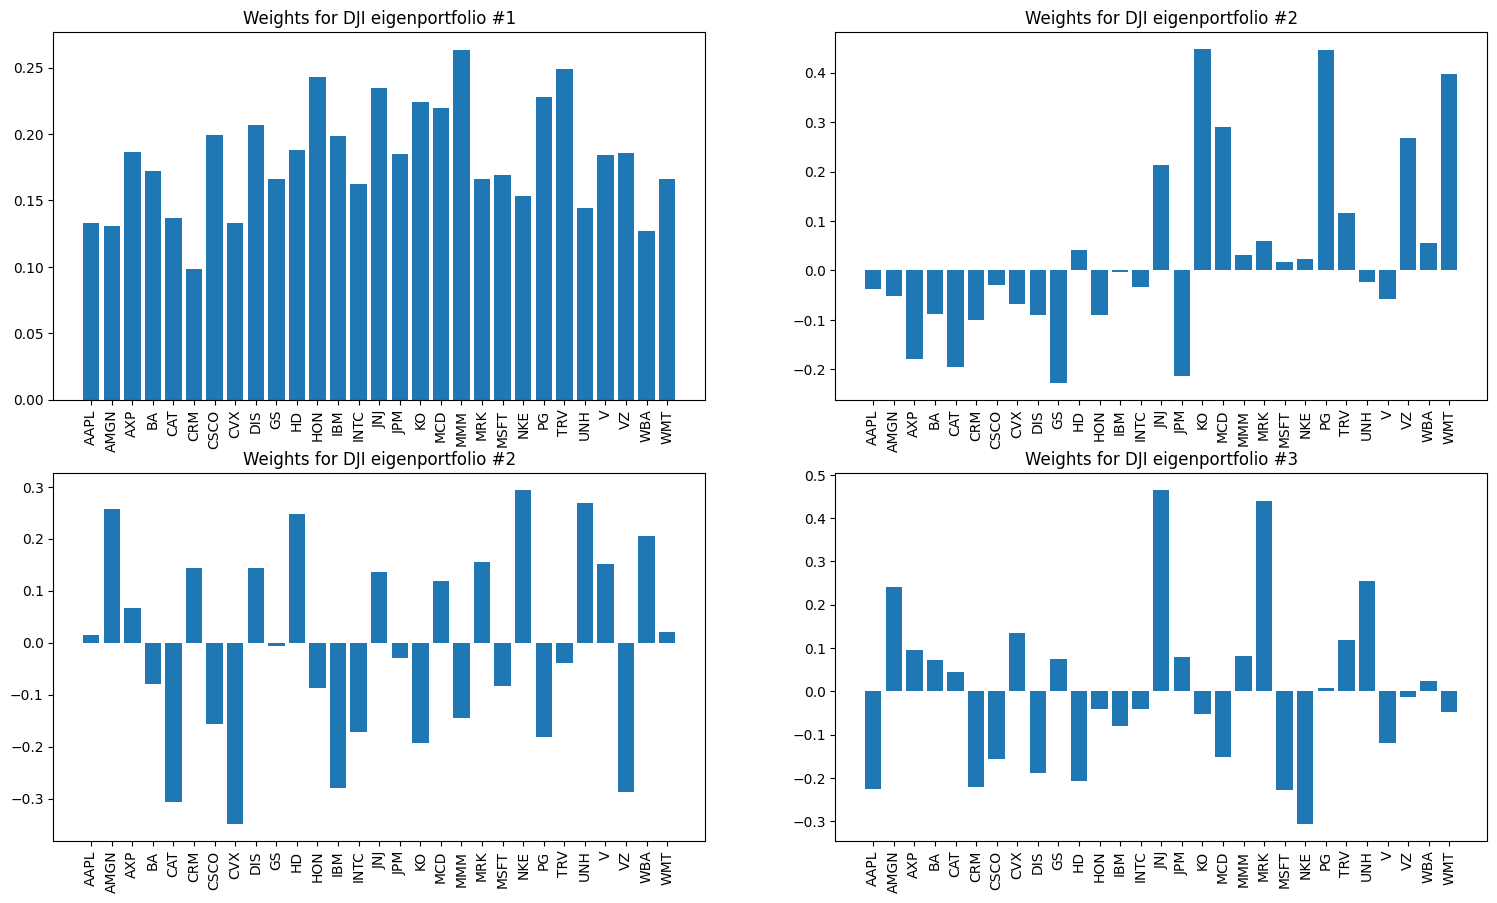

In [69]:
fig, axes = plt.subplots(2,2,sharex=False)

axes[0,0].bar(np.arange(29),
              (DJI_evecs_std[:,0]/np.linalg.norm(DJI_evecs_std[:,0])),
             tick_label=DJI_train.columns);
axes[0,1].bar(np.arange(29),(DJI_evecs_std[:,1]/np.linalg.norm(DJI_evecs_std[:,1])),
             tick_label=DJI_train.columns);
axes[1,0].bar(np.arange(29),(DJI_evecs_std[:,2]/np.linalg.norm(DJI_evecs_std[:,2])),
             tick_label=DJI_train.columns);
axes[1,1].bar(np.arange(29),(DJI_evecs_std[:,3]/np.linalg.norm(DJI_evecs_std[:,3])),
             tick_label=DJI_train.columns);

for i in range(2):
    for j in range(2):
        axes[i,j].set_xticklabels(DJI_train.columns,rotation=90)
        axes[i,j].set_title(f'Weights for DJI eigenportfolio #{i+j+1}')

fig.set_size_inches(18.5, 10.5)

# Sharpe Ratio and Beta

Below we define a function to compute the sharpe ratio of an eigenportfolio. In general eigenvectors are not uniquely defined unless we specify some normalization condition. Given a matrix $M$ and an eigenvector $v$ (with eigenvalue $\lambda$) we can multiply $v$ by any constant and get another valid eigenvector:
\begin{align}
M(av)=a(Mv)=a\lambda v = \lambda (av).
\end{align}
Previously we imposes our eigenvectors had unit norm $v\cdot v=1$ which fixes this ambiguity up to an overall sign. If $\hat{v}$ is an eigenvector with unit norm, then $-\hat{v}$ is also an eigenvector with unit norm. To determine which sign we should choose, we compute the Sharpe ratio on the training set for both choices and pick the sign that produces a higher return. This is accomplished by the function below.

In [70]:
def sharpe_ratio(ts_returns, periods_per_year=252):
    """
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio of an eigenportfolio.
    
    Eigenvectors have a sign ambiguity, so we test two different eigenportfolios and return the results for whichever
    one gives better returns.

    Inputs:
    -------
    - ts_returns (pd.Series): returns of a single eigen portfolio.
    - periods_per_year (int): Number of trading days in a year.
    
    Outputs:
    -------
    - annualized_return (float): annualized return on portfolio.
    - annualized_vol (float): annualized volatility of portfolio.
    - annualized_sharpe (float): annualized sharpe ratio.
    - sign (int): +1 if original eigenvector gives better returns. 
                  -1 if -1*eigenvector gives better returns.
    """
    n_years = ts_returns.shape[0]/periods_per_year

    annualized_return_pos = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_return_neg = np.power(np.prod(1-ts_returns),(1/n_years))-1

    if annualized_return_pos>annualized_return_neg:
        sign = 1
        annualized_return = annualized_return_pos
    else:
        sign = -1
        annualized_return = annualized_return_neg

    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe, sign

Below we compute the Sharpe ratio for the SP eigenportfolios and see that, on the training set, the top portfolios have a Sharpe ratio >2. However, we also need to check if this carries over to the test set before we start investing any money!

In [72]:
SP_train_sharpe = np.zeros((SP_eport_train.shape[1],4))

for i, col in enumerate(SP_eport_train.columns):
    SP_train_sharpe[i] = sharpe_ratio(SP_eport_train[col])

df_SP_summary = pd.DataFrame(SP_train_sharpe,columns=['return','vol','sharpe','sign'],
             index=np.arange(SP_train_sharpe.shape[0]))

top_SP_ports = df_SP_summary.sort_values(by='sharpe',ascending=False)[:5]
top_SP_ports_idx = top_SP_ports.index

top_SP_ports

,return,vol,sharpe,sign
466,0.069389,0.022725,3.053456,1.0
467,0.060508,0.023429,2.582634,-1.0
442,0.074021,0.033525,2.207927,-1.0
12,0.754620,0.344363,2.191353,1.0
464,0.053814,0.024595,2.187965,1.0


We see that the top eigenportfolios on the test set have a very high Sharpe ratio, and the 0th eigenportfolio performs remarkably well (which is likely an artifact of the particular time window we are looking at). However, its also important to note that the top eigenportfolios on the training set are not the top portfolios on the test set!

In [73]:
SP_test_sharpe = np.zeros((SP_eport_test.shape[1],4))

for i, col in enumerate(SP_eport_test.columns):
    SP_test_sharpe[i] = sharpe_ratio(SP_eport_test[col])

df_SP_test_summary = pd.DataFrame(SP_test_sharpe,columns=['return','vol','sharpe','sign'],
             index=np.arange(SP_test_sharpe.shape[0]))

df_SP_test_summary.sort_values(by='sharpe',ascending=False)[:5]

,return,vol,sharpe,sign
0,24.029650,1.388495,17.306256,-1.0
233,0.545398,0.121103,4.503598,-1.0
50,0.743122,0.182794,4.065347,1.0
414,0.374523,0.092748,4.038085,1.0
308,0.442037,0.110102,4.014799,-1.0


Below we see that the top eigenportfolios of the training set have a much smaller Sharpe ratio on the test set. This is of course indicating that the stock market is behaving very differently between the train and test sets and we either need to use shorter time-periods or incorporate time-series analysis.

In [75]:
df_SP_test_summary.loc[top_SP_ports.index]

,return,vol,sharpe,sign
466,0.090940,0.083283,1.091938,1.0
467,0.053855,0.088783,0.606586,-1.0
442,0.013142,0.102919,0.127691,-1.0
12,0.020520,0.279470,0.073424,1.0
464,0.076501,0.107289,0.713032,-1.0


Below we repeat the same analysis for stocks in the DJI train and test datasets. We observe that the only overlap between the top 5 eigenportfolios in our two datasets is the 0th one, which is the proxy for the market.

In [76]:
DJI_train_sharpe = np.zeros((DJI_eport_train.shape[1],4))

for i, col in enumerate(DJI_eport_train.columns):
    DJI_train_sharpe[i] = sharpe_ratio(DJI_eport_train[col])

df_DJI_summary = pd.DataFrame(DJI_train_sharpe,columns=['return','vol','sharpe','sign'],
             index=np.arange(DJI_train_sharpe.shape[0]))

top_DJI_ports = df_DJI_summary.sort_values(by='sharpe',ascending=False)[:5]

top_DJI_ports

,return,vol,sharpe,sign
0,0.703209,0.601101,1.169869,1.0
12,0.108368,0.120950,0.895978,-1.0
6,0.113724,0.141852,0.801705,1.0
26,0.070677,0.092483,0.764217,-1.0
14,0.085989,0.120168,0.715574,1.0


In [77]:
DJI_test_sharpe = np.zeros((DJI_eport_test.shape[1],4))

for i, col in enumerate(DJI_eport_test.columns):
    DJI_test_sharpe[i] = sharpe_ratio(DJI_eport_test[col])

df_DJI_test_summary = pd.DataFrame(DJI_test_sharpe,columns=['return','vol','sharpe','sign'],
             index=np.arange(DJI_test_sharpe.shape[0]))

df_DJI_test_summary.sort_values(by='sharpe',ascending=False)[:5]

,return,vol,sharpe,sign
0,1.879014,0.309159,6.077826,1.0
17,0.520582,0.134823,3.861219,-1.0
19,0.284109,0.109469,2.595342,-1.0
24,0.207815,0.091243,2.277593,-1.0
10,0.261806,0.115964,2.257643,1.0


Finally, we also observe the the top eigenportfolios in the training set mostly have a smaller Sharpe ratio on the test set, with the 0th and 26th portfolios being the notable exceptions.

In [78]:
df_DJI_test_summary.loc[top_DJI_ports.index]

,return,vol,sharpe,sign
0,1.879014,0.309159,6.077826,1.0
12,0.028640,0.117755,0.243221,-1.0
6,0.081115,0.128610,0.630702,1.0
26,0.109243,0.090152,1.211771,-1.0
14,0.013784,0.128717,0.107089,-1.0


Finally, lets compute the beta's for the SP-500 and DJI eigenportfolios. Here we define the beta coefficient to be:
\begin{align}
\beta_i = \frac{\text{Cov}(R_i,R_{\text{index}})}{\text{Var}(R_{\text{index}})}
\end{align}
where $R_i$ is the return on eigenportfolio $i$ and $R_{\text{index}}$ is the reward on the associated index (either SP-500 or DJI)$. In other words, $\beta_i$ is measuring how sensitive our portfolio is to changes in the market.

In [81]:
Beta = {}

for i in SP_eport_train.columns:

    Beta['SP','train',i] = (np.cov(SP_eport_train[i].values,
                                  SP_idx_returns.loc[SP_eport_train.index].values)[0,1]
                            /np.var(SP_idx_returns.loc[SP_eport_train.index]))

    Beta['SP','train',i] *= df_SP_summary.loc[i,'sign']

    Beta['SP','test',i] = (np.cov(SP_eport_test[i],
                                 SP_idx_returns.loc[SP_eport_test.index])[0,1]
                           /np.var(SP_idx_returns.loc[SP_eport_test.index]))

    Beta['SP','test',i] *= df_SP_test_summary.loc[i,'sign']

for i in DJI_eport_train.columns:

    Beta['DJI','train',i] = (np.cov(DJI_eport_train[i],
                                   DJI_idx_returns.loc[DJI_eport_train.index])[0,1]
                             /np.var(DJI_idx_returns.loc[DJI_eport_train.index]))

    Beta['DJI','train',i] *= df_DJI_summary.loc[i,'sign']

    Beta['DJI','test',i] = (np.cov(DJI_eport_test[i],
                                  DJI_idx_returns.loc[DJI_eport_test.index])[0,1]
                            /np.var(DJI_idx_returns.loc[DJI_eport_test.index]))

    Beta['DJI','test',i] *= df_DJI_test_summary.loc[i,'sign']

In the cell below we compare the beta-coefficients on the train and test set for both sets of eigenportfolios. We only look at the top-5 eigenportfolios, but one can compare them more systematically. We observe that the beta for the 0th eigenportfolio is fairly stable while the other eigenportfolios can change dramatically. For the 2nd-highest eigenportfolio of the SP-500 we see beta goes from -0.019 to 2.362. Evidently this portfolio became more sensitive to the market during the test set period. In general this appears to be a trend, the beta coefficients during the test set tend to be larger.

In [82]:
print('Beta for SP-500 Eigenportfolios:\n')
for i in range(5):
    print(f"Portfolio {i}: train = {round(Beta['SP','train',i],3)}, test = {round(Beta['SP','test',i],3)}")

print('\nBeta for DJI Eigenportfolios:\n')
for i in range(5):
    print(f"Portfolio {i}: train = {round(Beta['DJI','train',i],3)}, test = {round(Beta['DJI','test',i],3)}")

Beta for SP-500 Eigenportfolios:

Portfolio 0: train = 18.578, test = 19.547
Portfolio 1: train = -0.019, test = 2.362
Portfolio 2: train = -0.088, test = 1.124
Portfolio 3: train = -0.06, test = 0.199
Portfolio 4: train = 0.206, test = 0.113

Beta for DJI Eigenportfolios:

Portfolio 0: train = 4.599, test = 4.42
Portfolio 1: train = -0.081, test = -0.638
Portfolio 2: train = -0.072, test = 0.296
Portfolio 3: train = -0.04, test = -0.119
Portfolio 4: train = -0.086, test = 0.141


We can observe the increased sensitivity to the market for all the DJI eigenportfolios. With the exception of portfolios 0 and 15 all the eigenportfolios become more sensitive to the market during the test set period. 

In [111]:
print('#, Ratio\n')
for i in DJI_eport_train.columns:
    print(f'{i}, {round(abs((Beta["DJI","test",i])/Beta["DJI","train",i]),3)}')

#, Ratio

0, 0.961
1, 7.888
2, 4.09
3, 2.951
4, 1.64
5, 26.659
6, 25.199
7, 23.9
8, 6.974
9, 42.083
10, 17.963
11, 2.964
12, 5.961
13, 112.577
14, 11.073
15, 0.297
16, 2.884
17, 6.68
18, 31.759
19, 18.895
20, 7.838
21, 14.996
22, 4.63
23, 65.566
24, 34.812
25, 4.396
26, 17.091
27, 2.776
28, 29.52


In [ ]:
PCA_SP_dr = PCA(n_components = 'mle').fit(SP_train_scaled)
PCA_DJI_dr = PCA(n_components = 'mle').fit(DJI_train_scaled)

In [ ]:
SP_train_reconst = PCA_SP_dr.inverse_transform(
    PCA_SP_dr.transform(SP_train_scaled))
SP_test_reconst = PCA_SP_dr.inverse_transform(
    PCA_SP_dr.transform(SP_test_scaled))


DJI_train_reconst = PCA_DJI_dr.inverse_transform(
    PCA_DJI_dr.transform(DJI_train_scaled))
DJI_test_reconst = PCA_DJI_dr.inverse_transform(
    PCA_DJI_dr.transform(DJI_test_scaled))

In [ ]:
print(np.sqrt(np.linalg.norm(SP_train_reconst-SP_train_scaled.values,
               ord='fro')/np.linalg.norm(SP_train_scaled.values,
               ord='fro')))

print(np.sqrt(np.linalg.norm(SP_test_reconst-SP_test_scaled.values,
               ord='fro')/np.linalg.norm(SP_test_scaled.values,
               ord='fro')))

In [ ]:
print(np.sqrt(np.linalg.norm(DJI_train_reconst-DJI_train_scaled.values,
               ord='fro')/np.linalg.norm(DJI_train_scaled.values,
               ord='fro')))

print(np.sqrt(np.linalg.norm(DJI_test_reconst-DJI_test_scaled.values,
               ord='fro')/np.linalg.norm(DJI_test_scaled.values,
               ord='fro')))

# Time-Series Predictions

The plot_correlogram function makes four plots for a time-series capturing useful information. Let's go through these plots in order:

1) In the upper, left hand corner we plot time-series itself as well its 21-day rolling average. In the upper left hand corner of the plot we also give the p-value for the Augmented Dickey-Fuller unit root test. 

2) In the upper, right hand corner we plot the quantiles of the empirical probability distribtuion against the theoretical quantiles of a normal distribution. A straight line indicates that we have a normal distribution. In the upper left hand corner of the plot we also give the mean, standard deviation, skew, and kurtosis for the empirical distribution.

3) In the lower, left hand corner we plot the autocorrelation function. This measures how correlated our time-series is at one time with values at previous times. By default we exclude the $0^{th}$ lag, since this autocorrelation is always 1.

4) In the lower, right hand corner we plot the partial autocorrelation function. The partial auto-correlation at lag-$k$ computes the correlation of a time series with its $k^{\text{th}}$ where we've also subtracted off the effects of smaller lags. Once again, we exclude the $0^{th}$ lag since it is always 1.

In [146]:
def plot_correlogram(x,
                     lags=None,
                     title=None,
                     alpha=.05):
    """
    Plots a time series x as well as probability distribution, autocorrelation, and partial autocorrelation plots.
    
    Inputs:
    -------
    - x (pd.Series): time series data, typically stock returns.
    - lags (int): Number of lags to include in (partial-)auto-correlation plots.
    - title (str): Title of plot
    - alpha (float): Confidence intervals for (partial-)auto-correlation plots.
    
    Output:
    ------
    - None
    """

    lags = min(10, int(len(x)/5)) if lags is None else lags

    with sns.axes_style('whitegrid'):

        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)

        stats = f'ADF: {adfuller(x)[1]:>11.2f}'

        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)

        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'

        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)

        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0], auto_ylims=True, alpha=alpha)
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1], auto_ylims=True, alpha=alpha)

        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')

        fig.suptitle(title, fontsize=20)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

## ARMA Models

In this section we plot the returns of the SP and DJI eignportfolios and fit the returns using ARMA models. We observe that for all eigenportfolios the residuals look like they are normally distributed and the mean returns are fit using the simplest ARMA(p,q), namely the constant model with p=q=0. In a little more detail we observe the following: 

1. The residual plots (the ones in the upper-left-hand corner) appear noisy with some large jumps, but the returns do fluctuate around an approximately constant mean. We also observe that the p-values for the ADF test are all essentially zero, indicating that we can reject the null hypothesis that there is a unit-root.

2. The probabiliy plots are mostly straight lines, except for some deviations for the lower and upper quantiles. This is indicated that the residuals appear to be normally distributed, with some possible heavy tails.

3. The autocorrelation and partial autocorrelation plots do not reveal any significant form of auto-correlations in the returns. To make this observation more concrete, later we will fit ARMA models for low $p$ and $q$ to our time-series and see that the models with the lowest PIC correspond to constant models.

### S&P-500

In this subsection we make time-series plots for the SP eigenportfolios and also fit ARMA models to the time-series returns.

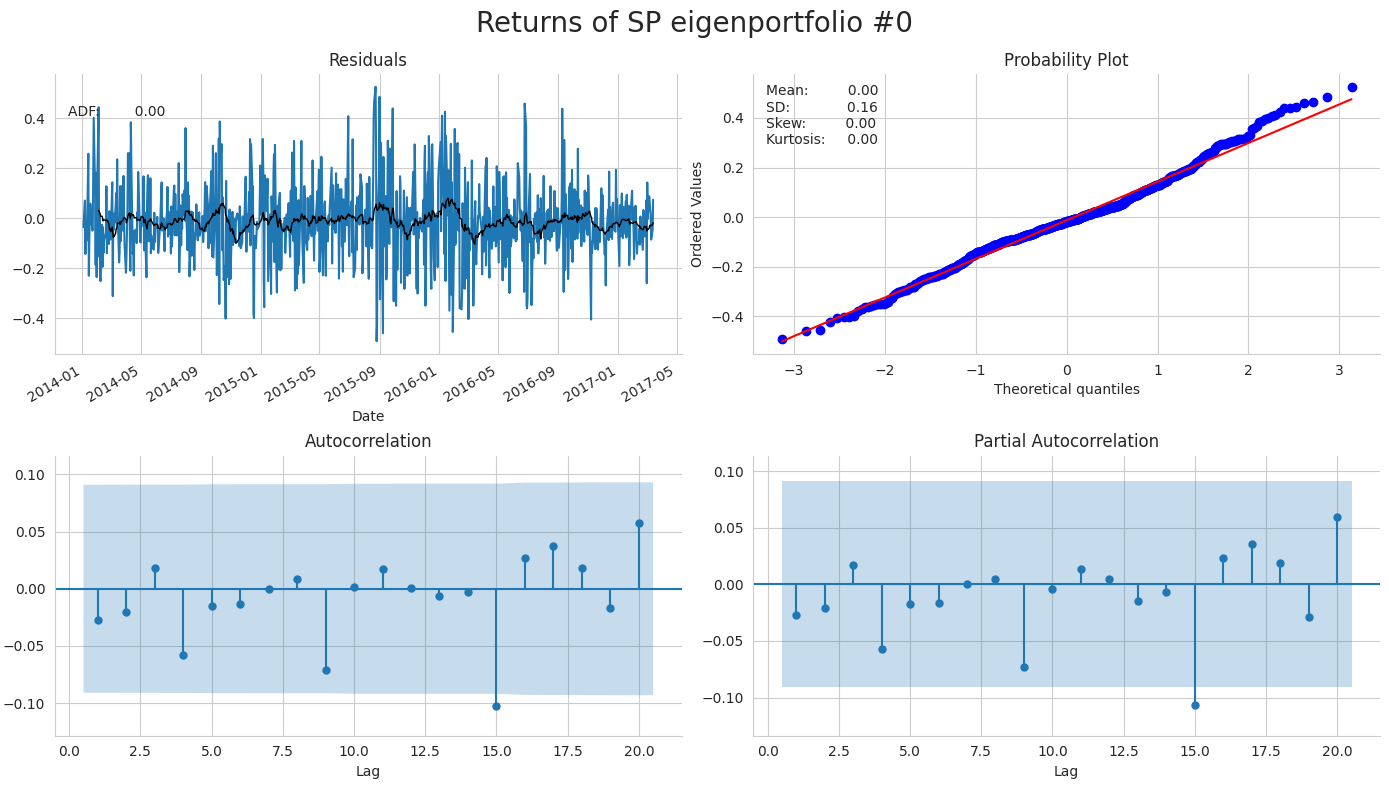

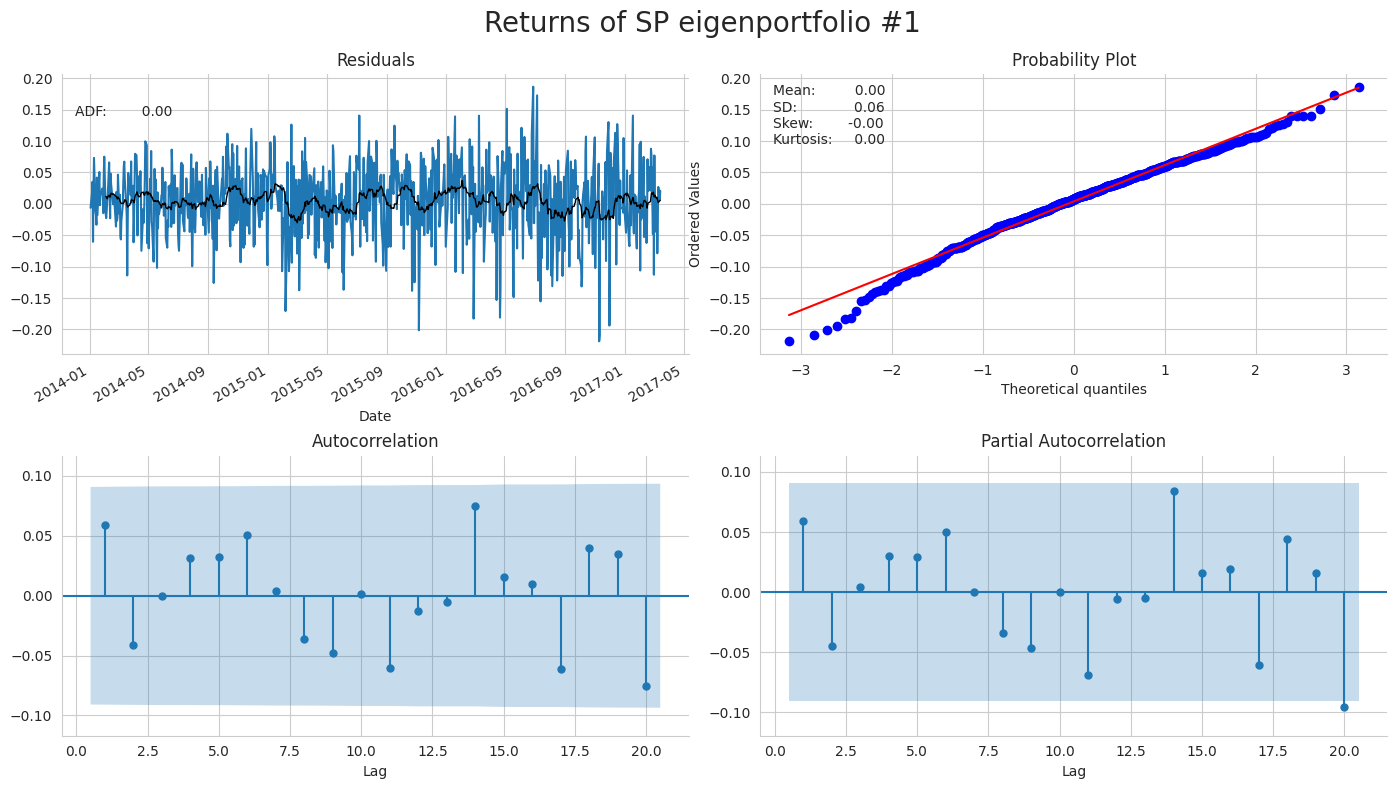

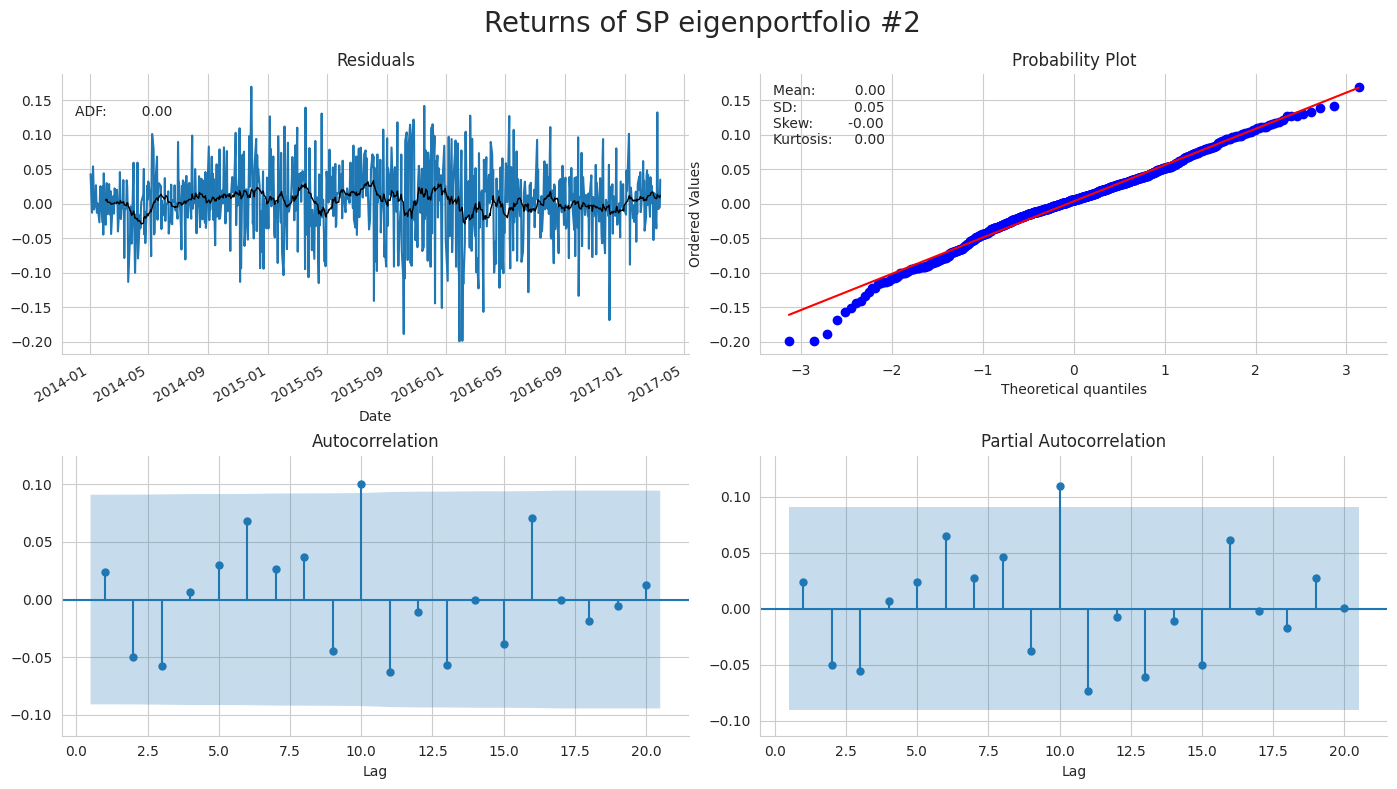

In [147]:
for i in range(3):
    plot_correlogram(SP_eport_train[i],lags=20,title=f'Returns of SP eigenportfolio #{i}',alpha=0.01)

Below we train our ARMA models on rolling windows of size 500 that cover the entire training set. We then perform a 1-day forecast and measure how the models prediction compares with the actual answer (specifically we measure the root-mean-squared error). In addition, for each window we measure the Akaike information criterion (AIC) and Bayesian information criterion (BIC) of our model. At the end of training, after covering the whole training set, we summarize the results by averaging the RMSE, AIC, and BIC over all the rolling windows. 

Since we are considering $p,q \in \{0,1,2,3,4\}$ (i.e. we are fitting 25 separate models) for the top-3 eigenportfolios, the code below can take a while to run. 

In [ ]:
train_size = 500
SP_ARIMA_results = {}
time_range = SP_eport_train.shape[0]


for j in range(3):
    SP_portfolio = SP_eport_train[j]
    y_true = SP_portfolio.iloc[train_size:]

    for p in range(5):
        for q in range(5):

            aic, bic = [], []
            rmse = []
            print(f'SP portfolio {j}, ARMA order = ({p},{q})')

            convergence_error = stationarity_error = 0

            for T in tqdm(range(train_size, time_range)):
                train_set = SP_portfolio.iloc[T-train_size:T]
                try:
                    model = tsa.ARIMA(endog=train_set, order=(p,0,q)).fit()

                    forecast = model.forecast(steps=1).values[0]

                    rmse.append((y_true[T-train_size]-forecast)**2)
                    aic.append(model.aic)
                    bic.append(model.bic)

                except LinAlgError:
                    convergence_error += 1
                    continue

                except ValueError:
                    stationarity_error += 1
                    continue


            SP_ARIMA_results[(j,p, q)] = [np.mean(rmse),
                                          np.mean(aic),
                                          np.mean(bic),
                                          convergence_error,
                                          stationarity_error]

Below we store our results in a Pandas DataFrame and save the results locally.

In [ ]:
df_SP_arima_results = pd.DataFrame(SP_ARIMA_results).T
df_SP_arima_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
df_SP_arima_results.index.names = ['i','p', 'q']
df_SP_arima_results.info()

os.makedirs('./results', exist_ok=True)
df_SP_arima_results.to_csv('./results/SP_arima_results.csv')

In the code below we load our saved results and for each eigenportfolio we look for the model with the smallest BIC. We store the optimal (p,q) in the list **SP_best_arima**.

In [148]:
df_SP_arima_results = pd.read_csv('./results/SP_arima_results.csv',index_col=['i','p','q'])

SP_best_arima = []

for i in range(3):

    bic_best = float('inf')
    p_best, q_best = None, None

    for p in range(5):
        for q in range(5):
            bic_tmp = df_SP_arima_results.loc[i,p,q].BIC

            if bic_tmp < bic_best:
                bic_best = bic_tmp
                p_best, q_best = p, q
    SP_best_arima.append((i,p_best,q_best))

We find that for all three eigenportfolios the best performing models have $p=q=0$.

In [162]:
for best_pq in SP_best_arima:
    i,p,q = best_pq
    print(f'Portfolio {i}: (p,q) = {p,q}')

Portfolio 0: (p,q) = (0, 0)
Portfolio 1: (p,q) = (0, 0)
Portfolio 2: (p,q) = (0, 0)


### DJI

Below, we repeat our analysis for the top-3 DJI eigenportfolios. The results are essentially the same as before so we will not go through them again in detail. The important point is that the returns look like they are best fit with a constant model and that, modulo some heavy tails, the returns also look normally distributed.

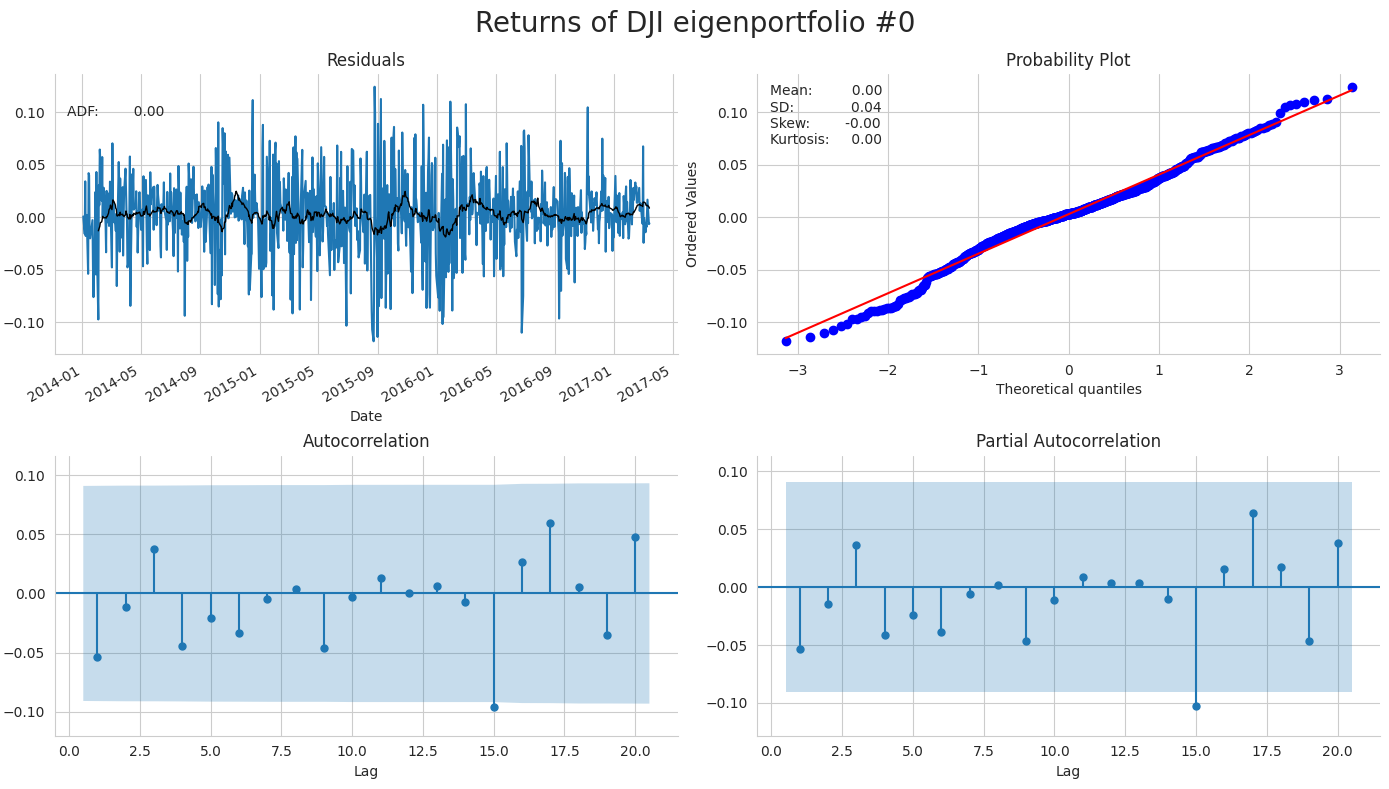

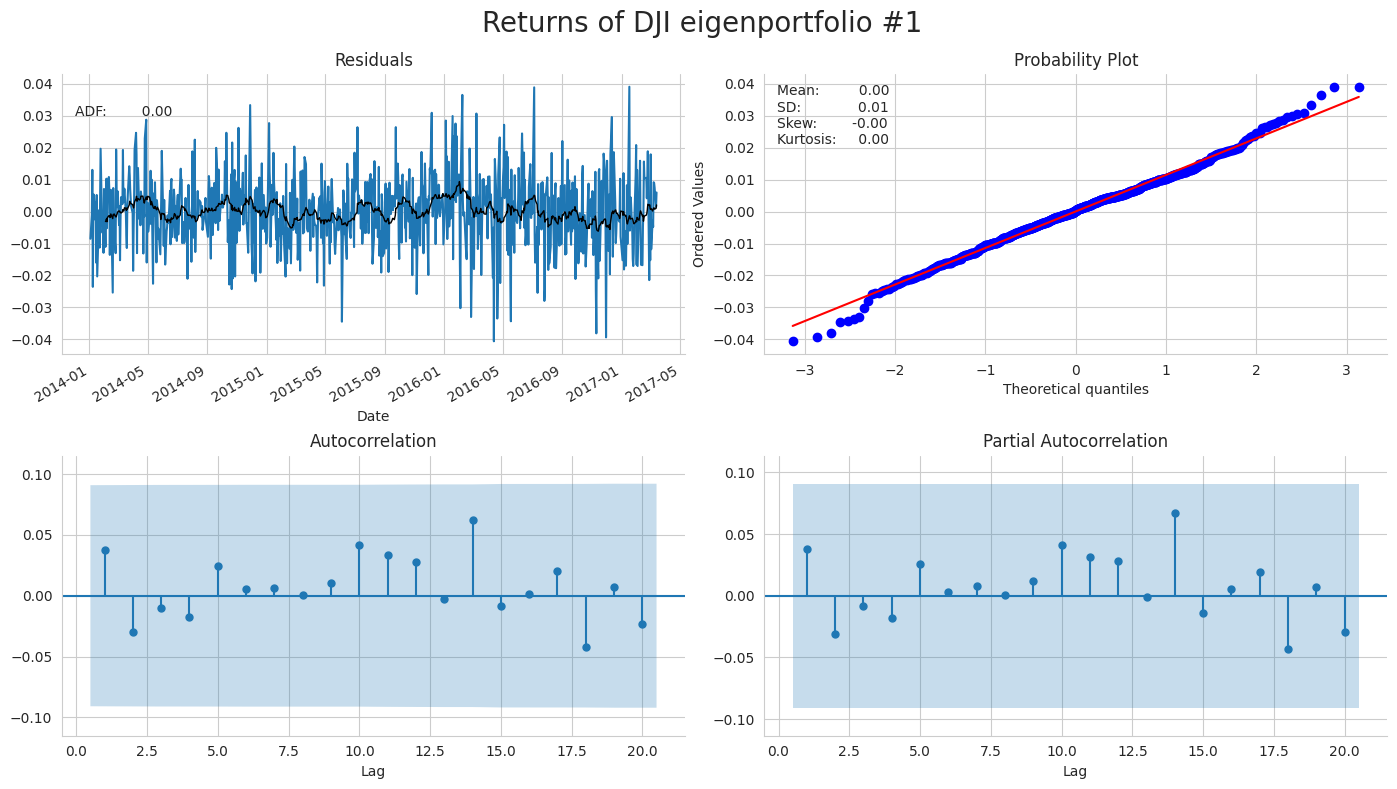

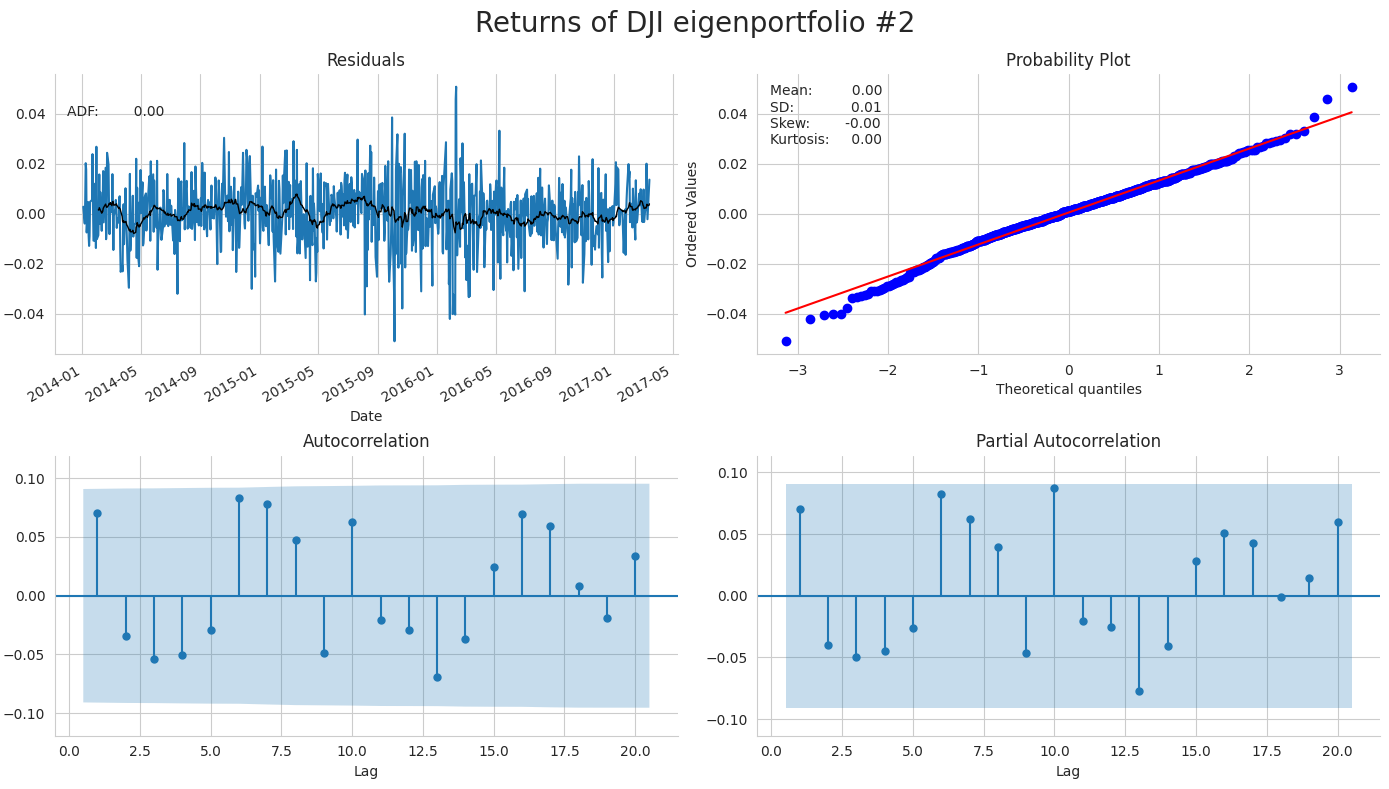

In [155]:
for i in range(3):
    plot_correlogram(DJI_eport_train[i],lags=20,title=f'Returns of DJI eigenportfolio #{i}',
                    alpha=.01)

Below we fit ARMA(p,q) models to the DJI eigenportfolios where we again train the model on a rolling window of fixed size, perform a one-step forecast, and compare with the known result. In addition, after fitting the model we also compute the AIC and BIC. All three metrics, the error, AIC, and BIC, are averaged across all the rolling windows.

In [ ]:
train_size = 500
DJI_ARIMA_results = {}
time_range = DJI_eport_train.shape[0]


for j in range(3):
    DJI_portfolio = DJI_eport_train[j]
    y_true = DJI_portfolio.iloc[train_size:]

    for p in range(5):
        for q in range(5):

            aic, bic = [], []
            rmse = []
            print(f'DJI portfolio {j}, ARMA order = ({p},{q})')

            convergence_error = stationarity_error = 0

            for T in tqdm(range(train_size, time_range)):
                train_set = DJI_portfolio.iloc[T-train_size:T]
                try:
                    model = tsa.ARIMA(endog=train_set, order=(p,0,q)).fit()

                    forecast = model.forecast(steps=1).values[0]

                    rmse.append((y_true[T-train_size]-forecast)**2)
                    aic.append(model.aic)
                    bic.append(model.bic)

                except LinAlgError:
                    convergence_error += 1
                    continue

                except ValueError:
                    stationarity_error += 1
                    continue


            DJI_ARIMA_results[(j,p, q)] = [np.mean(rmse),
                                          np.mean(aic),
                                          np.mean(bic),
                                          convergence_error,
                                          stationarity_error]

In [ ]:
df_DJI_ARIMA_results = pd.DataFrame(DJI_ARIMA_results).T
df_DJI_ARIMA_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
df_DJI_ARIMA_results.index.names = ['i','p', 'q']
df_DJI_ARIMA_results.info()

df_DJI_ARIMA_results.to_csv('./results/DJI_ARIMA_results.csv')

For each eignportfolio we find the model parameters with the lowest BIC and append the results to the list **DJI_best_arima**.

In [156]:
df_DJI_ARIMA_results= pd.read_csv('./results/DJI_ARIMA_results.csv',index_col=['i','p','q'])

DJI_best_arima = []


for i in range(3):

    bic_best = float('inf')
    p_best, q_best = None, None

    for p in range(5):
        for q in range(5):
            bic_tmp = df_DJI_ARIMA_results.loc[i,p,q].BIC

            if bic_tmp < bic_best:
                bic_best = bic_tmp
                p_best, q_best = p, q
    DJI_best_arima.append((i,p_best,q_best))

Once again, we see the best performing models had $p=q=0$, i.e. we just fit the data with a constant function!

In [161]:
for best_pq in DJI_best_arima:
    i,p,q = best_pq
    print(f'Portfolio {i}: (p,q) = {p,q}')

Portfolio 0: (p,q) = (0, 0)
Portfolio 1: (p,q) = (0, 0)
Portfolio 2: (p,q) = (0, 0)


## Garch Models

In the previous section we saw that the returns of our eigenportfolios appeared very simple, the time-series could be fit using a constant model and the residuals appeared normally distributed. However, we also know this cannot be the full story since when we actually plot the residuals we see large jumps and they don't look like white noise.

In this section we improve on the previous analysis by accounting for heteroskedasticity, or that the volatility is not constant over time. To see this visually, we plot the following time-series:
\begin{align}
X_t = (R_{t}-\overline{R}_{t})^{2}
\end{align}
or the deviation between the return and its mean value, squared. When we plot this time series we observe that the autocorrelation and partial autocorrelation coefficients are large, which indicates that we need to model the volatility using an ARCH or GARCH process, see the Wikipedia <a href="https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity#">article</a> for more details as well as an extensive list of possible GARCH models.

To fit the GARCH model we will use the arch_model function from the arch library, see <a href="https://arch.readthedocs.io/en/latest/univariate/introduction.html">here</a> for more details. Given the results of the previous section, we will take the mean model to be constant. We will also assume the volatility model is GARCH, although it may be interesting to consider other possibilities. Finally, we will take the standardized residuals to follow a skew t-distribution. We use a t-distribution since it has heavier tails than a normal distribution and we also used a skew distribution since we expect that negative shocks to the stock prices may be larger than positive ones. 

With the exception of the fact that we are fitting GARCH models instead of ARMA models, the code in this section is largely the same as in the previous section.

### S&P-500

Below we explore the properties of the squared residuals. We observe that the squared residuals display a much more significant auto-correlation than the residuals do on their own. From the time-series plots we can also observe volatility clustering.

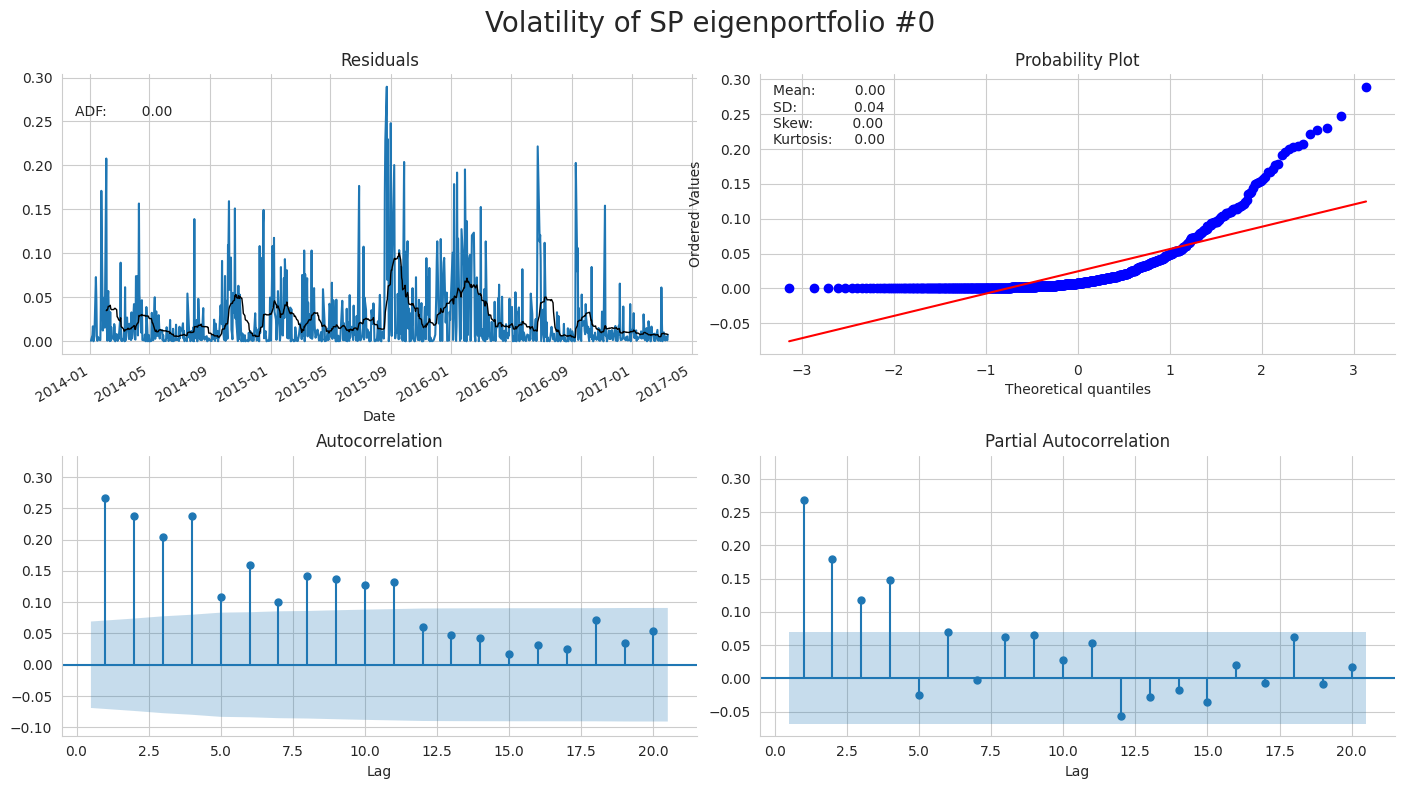

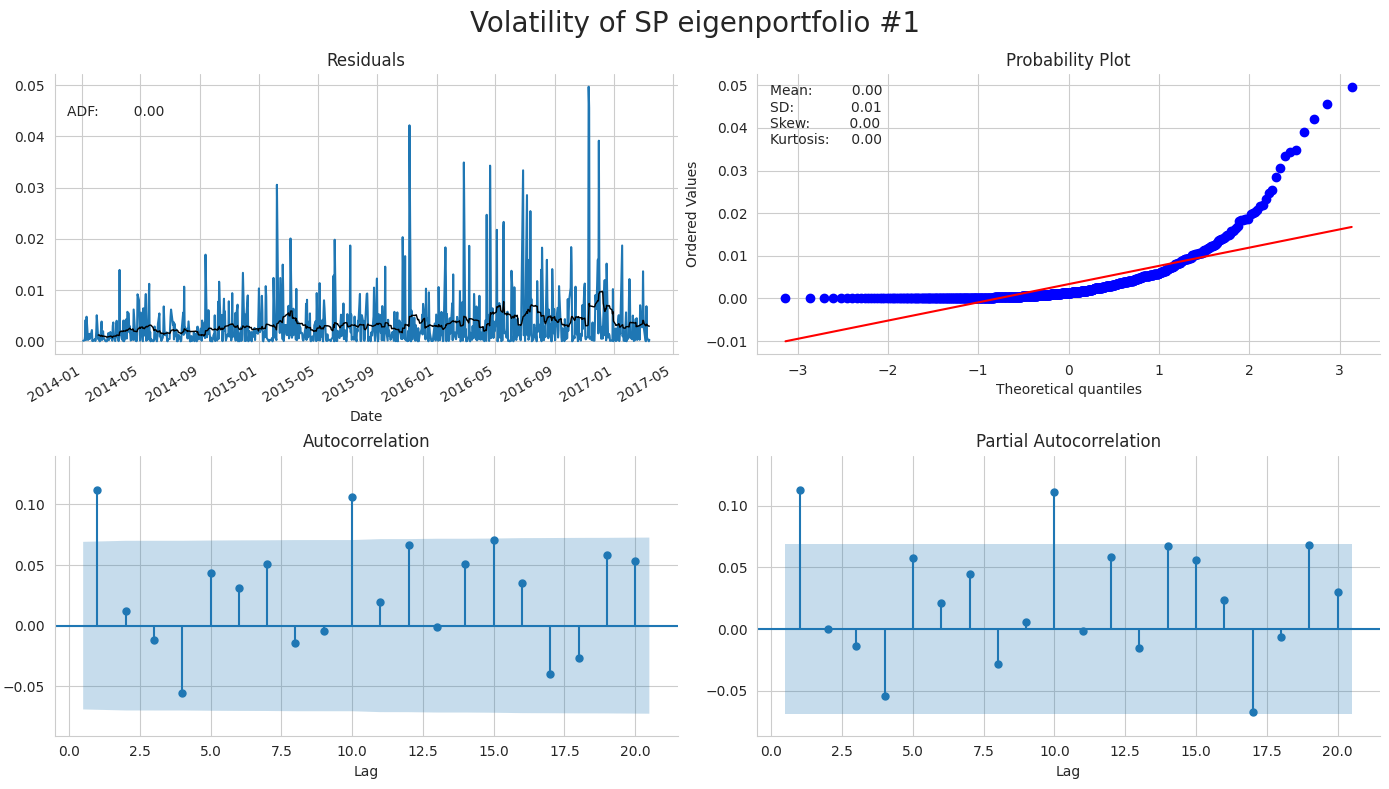

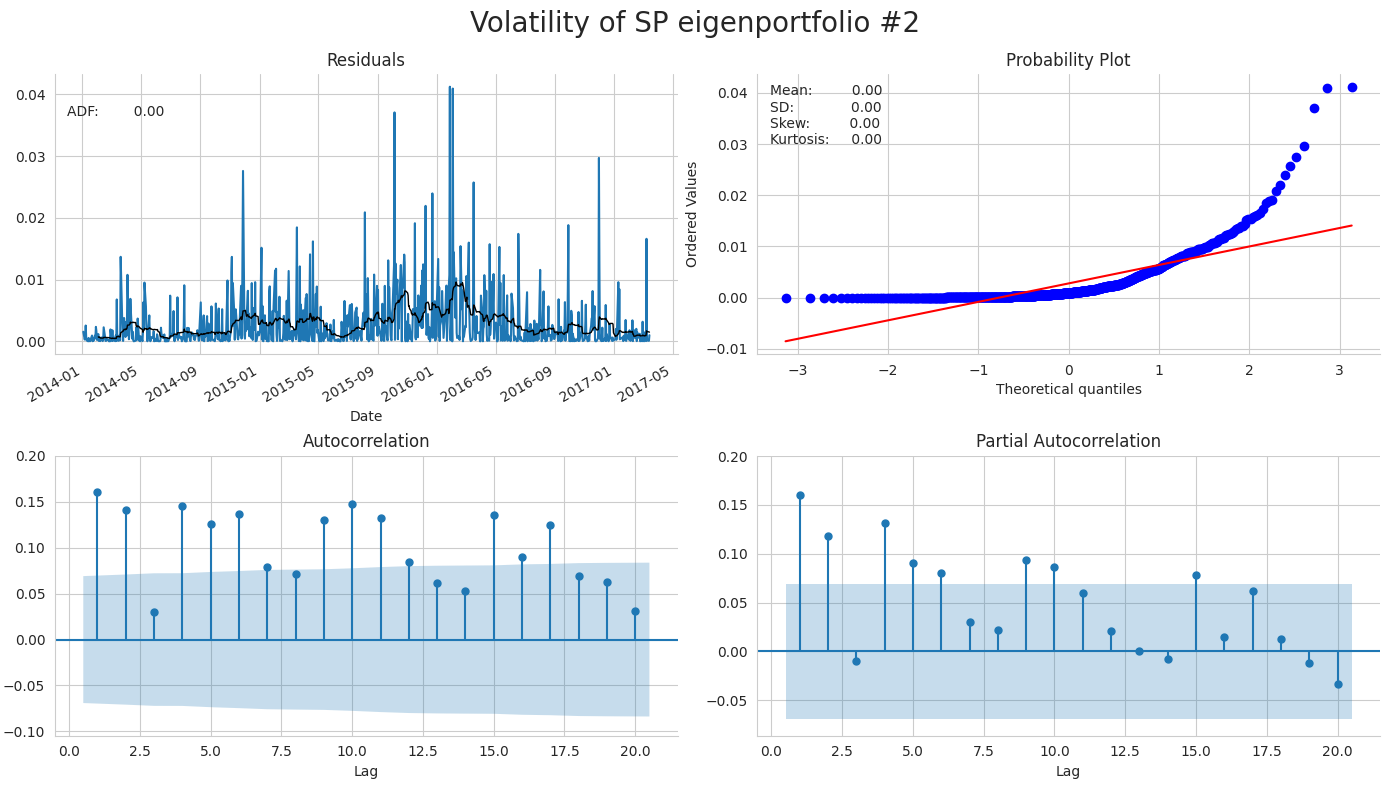

In [164]:
for i in range(3):
    plot_correlogram((SP_eport_train[i]-SP_eport_train[i].mean())**2,
                     lags=20,title=f'Volatility of SP eigenportfolio #{i}')

Below we train the GARCH models on rolling windows of size 500 and record the variance, error, AIC, and BIC for each window. At the end of training we compute the average of these quantities across all training windows.

In [ ]:
train_size = 500
SP_GARCH_results = {}
time_range = SP_eport_train.shape[0]


for j in range(3):
    SP_portfolio = SP_eport_train[j]
    SP_resid = SP_portfolio - SP_portfolio.mean()

    y_true = SP_resid.iloc[train_size:]

    for p in range(1,7):
        for q in range(7):

            aic, bic = [], []
            rmse = []
            var = []
            print(f'SP portfolio {j}, GARCH order = ({p},{q})')

            convergence_error = stationarity_error = 0
            y_pred = []

            for T in tqdm(range(train_size, time_range)):
                train_set = SP_resid.iloc[T-train_size:T]
                try:
                    model = arch_model(y = train_set,
                                       p = p,
                                       q = q,
                                       dist = 'skewt').fit(disp='off')

                    forecast = model.forecast(horizon=1)
                    mu = forecast.mean.iloc[-1,0]

                    var.append(forecast.variance.iloc[-1,0])
                    rmse.append((y_true[T-train_size]-mu)**2)
                    aic.append(model.aic)
                    bic.append(model.bic)
                    
                    del model

                except LinAlgError:
                    convergence_error += 1
                    continue

                except ValueError:
                    stationarity_error += 1
                    continue


            SP_GARCH_results[(j,p, q)] = [np.mean(rmse),
                                          np.mean(var),
                                          np.mean(aic),
                                          np.mean(bic),
                                          convergence_error,
                                          stationarity_error]

Below we store the final results in a Pandas DataFrame and save the result locally.

In [ ]:
df_SP_GARCH_results = pd.DataFrame(SP_GARCH_results).T
df_SP_GARCH_results.columns = ['RMSE','var', 'AIC', 'BIC', 'convergence', 'stationarity']
df_SP_GARCH_results.index.names = ['i','p', 'q']


df_SP_GARCH_results.to_csv('./results/df_SP_GARCH_results.csv')

Finally, below we pick out the best GARCH model by seeing which model minimizes the BIC.

In [168]:
SP_best_GARCH = []

df_SP_GARCH_results = pd.read_csv('./results/df_SP_GARCH_results.csv',index_col=['i','p','q'])


for i in range(3):

    bic_best = float('inf')
    p_best, q_best = None, None

    for p in range(1,7):
        for q in range(7):
            bic_tmp = df_SP_GARCH_results.loc[i,p,q].BIC

            if bic_tmp < bic_best:
                bic_best = bic_tmp
                p_best, q_best = p, q
                
    SP_best_GARCH.append((i,p_best,q_best))

In [170]:
for best_params in SP_best_GARCH:
    i, p, q = best_params
    print(f'Portfolio {i}: (p,q) = {p,q}')

Portfolio 0: (p,q) = (1, 1)
Portfolio 1: (p,q) = (2, 0)
Portfolio 2: (p,q) = (1, 1)


We find that now the best GARCH models are non-trivial and confirm the earlier plots which indiciated significant auto-correlation.

### DJI

Below we repeat the previous results, but now for the DJI eigenportfolios. Once again, we observe that the squared residuals indicate significant autocorrelation and that there is volatility clustering in our time-series plots. The degree of autocorrelation appears to be smaller in the second eigenportfolio in comparison to the first and third.

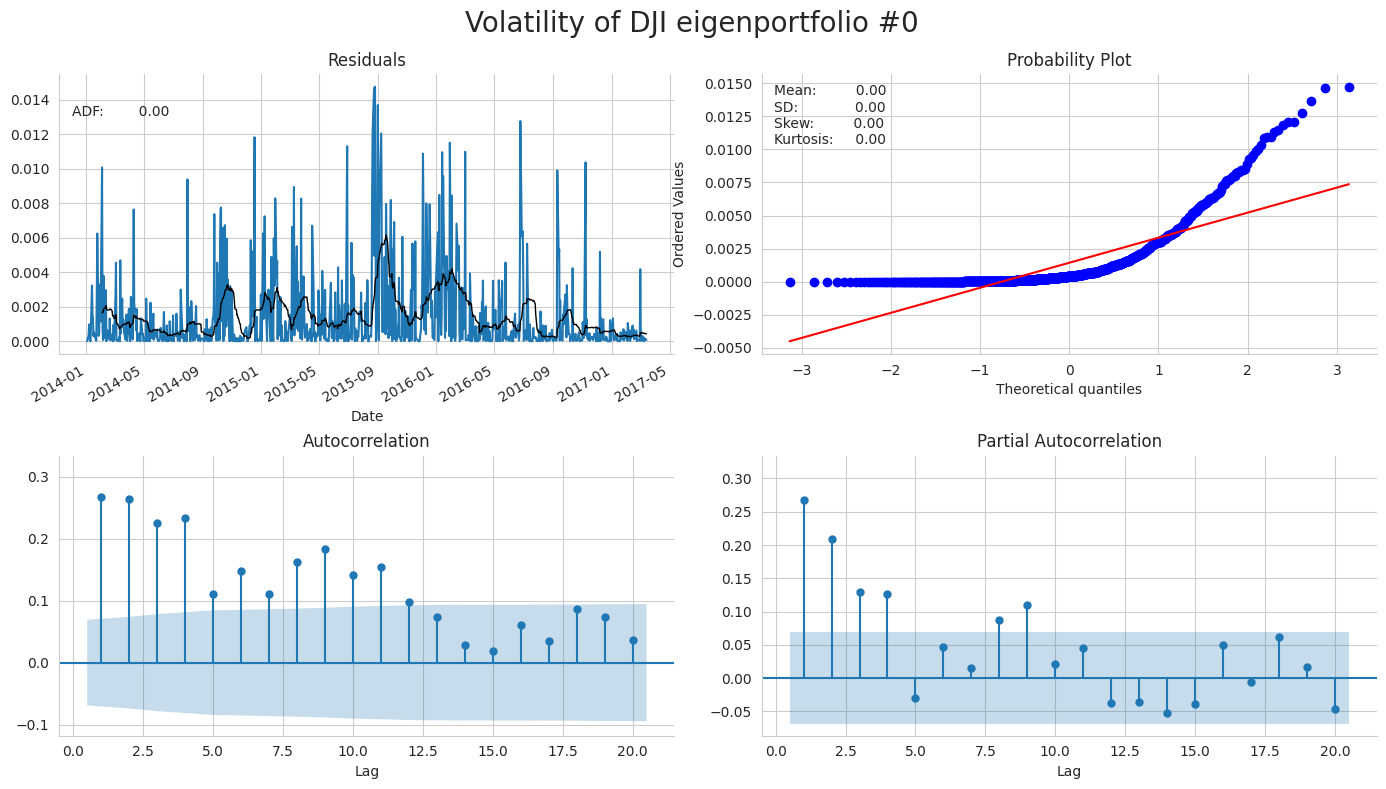

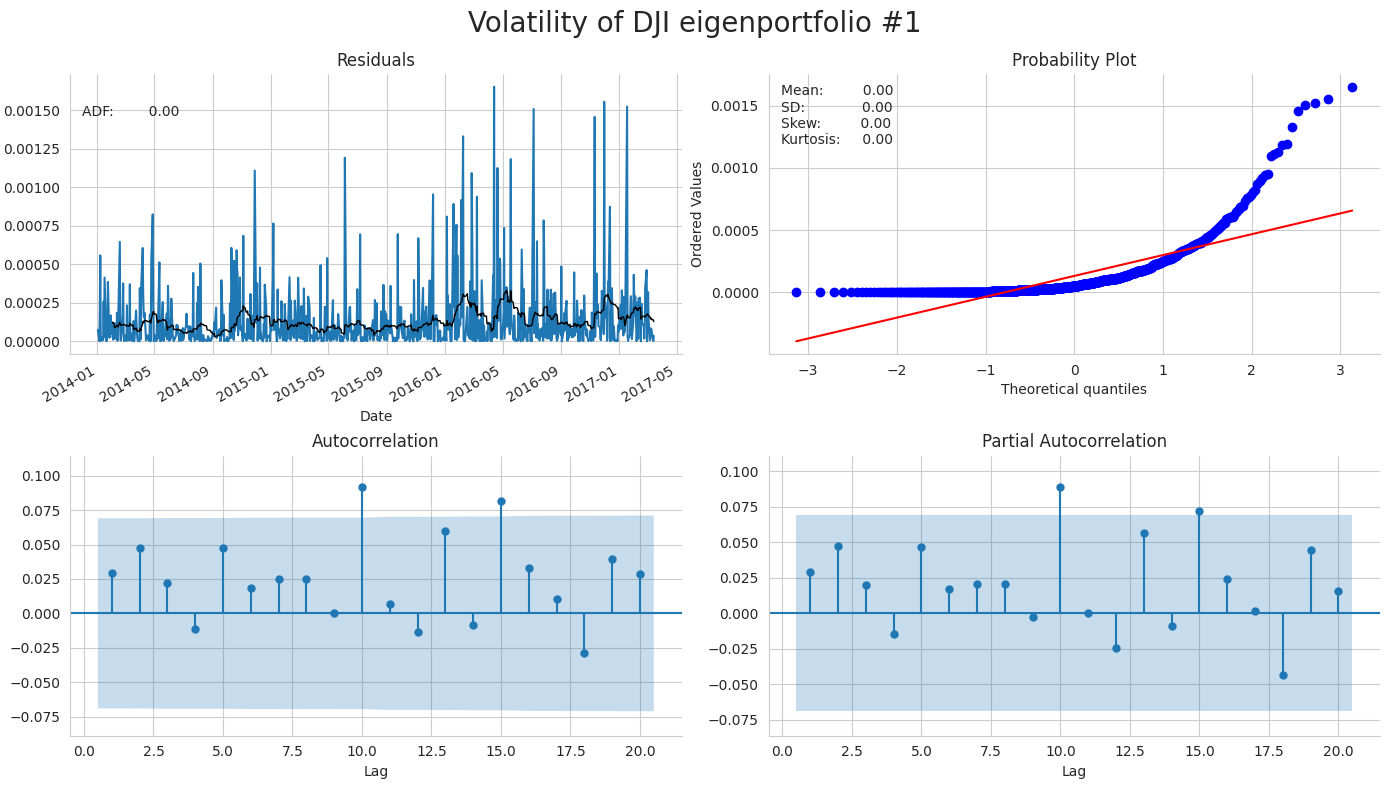

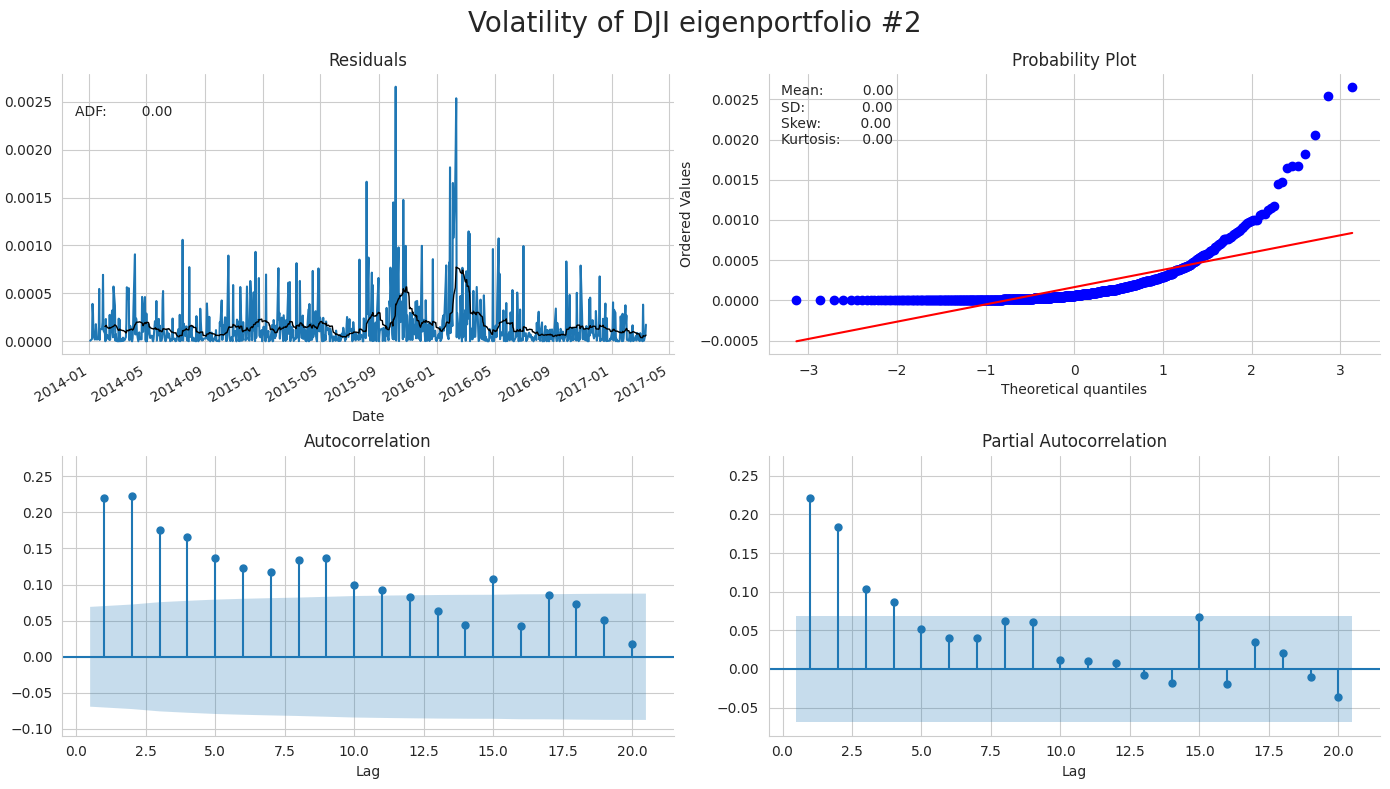

In [165]:
for i in range(3):
    plot_correlogram((DJI_eport_train[i]-DJI_eport_train[i].mean())**2,
                     lags=20,title=f'Volatility of DJI eigenportfolio #{i}')

Below we once again fit GARCH models to the squared residuals by training our model on rolling windows and then recording the one-step forecast error, the AIC, and the BIC.

In [ ]:
train_size = 500
DJI_GARCH_results = {}
time_range = DJI_eport_train.shape[0]


for j in range(3):
    DJI_portfolio = DJI_eport_train[j]
    DJI_resid = DJI_portfolio - DJI_portfolio.mean()

    y_true = DJI_resid.iloc[train_size:]

    for p in range(1,7):
        for q in range(7):

            aic, bic = [], []
            rmse = []
            var = []
            print(f'DJI portfolio {j}, GARCH order = ({p},{q})')

            convergence_error = stationarity_error = 0
            #y_pred = []

            for T in tqdm(range(train_size, time_range)):
                train_set = DJI_resid.iloc[T-train_size:T]
                try:
                    model = arch_model(y = train_set,
                                       p = p,
                                       q = q,
                                       dist = 'skewt').fit(disp='off')

                    forecast = model.forecast(horizon=1)
                    mu = forecast.mean.iloc[-1,0]

                    var.append(forecast.variance.iloc[-1,0])
                    rmse.append((y_true[T-train_size]-mu)**2)
                    aic.append(model.aic)
                    bic.append(model.bic)

                except LinAlgError:
                    convergence_error += 1
                    continue

                except ValueError:
                    stationarity_error += 1
                    continue


            DJI_GARCH_results[(j,p, q)] = [np.mean(rmse),
                                          np.mean(var),
                                          np.mean(aic),
                                          np.mean(bic),
                                          convergence_error,
                                          stationarity_error]

In [ ]:
df_DJI_GARCH_results = pd.DataFrame(DJI_GARCH_results).T
df_DJI_GARCH_results.columns = ['RMSE','var', 'AIC', 'BIC', 'convergence', 'stationarity']
df_DJI_GARCH_results.index.names = ['i','p', 'q']


df_DJI_GARCH_results.to_csv('./results/df_DJI_GARCH_results.csv')

In [171]:
DJI_best_GARCH = []
df_DJI_GARCH_results = pd.read_csv('./results/df_DJI_GARCH_results.csv',index_col=['i','p','q'])

for i in range(3):

    bic_best = float('inf')
    p_best, q_best = None, None

    for p in range(1,7):
        for q in range(7):
            bic_tmp = df_DJI_GARCH_results.loc[i,p,q].BIC

            if bic_tmp < bic_best:
                bic_best = bic_tmp
                p_best, q_best = p, q
                
    DJI_best_GARCH.append((i,p_best,q_best))

In [174]:
for best_params in DJI_best_GARCH:
    i, p, q = best_params
    print(f'Portfolio {i}: (p,q) = {p,q}')

Portfolio 0: (p,q) = (2, 1)
Portfolio 1: (p,q) = (2, 1)
Portfolio 2: (p,q) = (4, 1)


Once again, we observe that when fitting the squared residuals, there is a significant degree of auto-correlation and the volaitlity is best modelled with a GARCH process.